<a href="https://colab.research.google.com/github/MatiMajewski/Beginners/blob/main/Untitled6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [265]:
!pip install pandas openpyxl



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [266]:
import pandas as pd

In [267]:
import pandas as pd
from IPython.display import display
from pathlib import Path
import re
import csv

csv_name = "RYNE_3786_CREL_20251207150625.csv"
preferred_paths = [
    Path(csv_name),
    Path.cwd() / csv_name,
    Path.home() / "OneDrive" / "Desktop" / "Projekt analiza danych w r i phyton" / "Beginners" / csv_name,
    Path.home() / csv_name,
]

# Pick the first existing path; fallback to a home-wide search if needed.
data_path = next((p for p in preferred_paths if p.exists()), None)
if data_path is None:
    matches = list(Path.home().rglob(csv_name))
    if matches:
        data_path = matches[0]
    else:
        raise FileNotFoundError(f"Nie znaleziono pliku {csv_name}.")

print(f"Uzywam pliku: {data_path}")

dane = pd.read_csv(
    data_path,
    delimiter=";",
    encoding="utf-8",
    on_bad_lines="skip",
    quoting=csv.QUOTE_MINIMAL,
    quotechar='"',
)

# Normalizacja nazw kolumn i tekstow
dane.columns = dane.columns.str.strip().str.strip('"')
string_cols = [
    "Nazwa",
    "Transakcje rynkowe",
    "Powierzchnia użytkowa lokali mieszkalnych",
    "Jednostka miary",
    "Atrybut",
]
for col in string_cols:
    if col in dane.columns:
        dane[col] = dane[col].astype(str).str.strip().str.strip('"')

# Liczbowe kolumny
for num_col in ["Rok", "Wartosc"]:
    if num_col in dane.columns:
        dane[num_col] = (
            dane[num_col]
            .astype(str)
            .str.replace("\u00a0", "", regex=False)
            .str.replace(" ", "", regex=False)
            .str.strip()
            .str.strip('"')
        )
        dane[num_col] = pd.to_numeric(dane[num_col], errors="coerce")

# Format kod as 00-000, case-insensitive column match
kod_col = next((c for c in dane.columns if c.lower() == "kod"), None)
if kod_col:
    def format_kod(val):
        digits = re.sub(r"\D", "", str(val))
        if not digits:
            return pd.NA
        digits = digits[:5].zfill(5)
        return f"{digits[:2]}-{digits[2:]}"

    dane[kod_col] = dane[kod_col].apply(format_kod)

# Usuniecie niepotrzebnych kolumn
dane = dane.drop(columns=["Atrybut", "Unnamed: 8"], errors="ignore")

display(dane)


Uzywam pliku: RYNE_3786_CREL_20251207150625.csv


Kod                  Nazwa Transakcje rynkowe  \
0     00-000                 POLSKA    rynek pierwotny   
1     00-000                 POLSKA    rynek pierwotny   
2     00-000                 POLSKA    rynek pierwotny   
3     00-000                 POLSKA    rynek pierwotny   
4     00-000                 POLSKA    rynek pierwotny   
...      ...                    ...                ...   
5950  32-630  Powiat m. Świnoujście    rynek pierwotny   
5951  32-630  Powiat m. Świnoujście    rynek pierwotny   
5952  32-630  Powiat m. Świnoujście    rynek pierwotny   
5953  32-630  Powiat m. Świnoujście    rynek pierwotny   
5954  32-630  Powiat m. Świnoujście    rynek pierwotny   

     Powierzchnia użytkowa lokali mieszkalnych   Rok   Wartosc Jednostka miary  
0                                       ogółem  2010 309936.00              zł  
1                                       ogółem  2011 314723.00              zł  
2                                       ogółem  2012 304789.00              zł  
3                                       ogółem  2013 300364.00              zł  
4                                       ogółem  2014 300784.00              zł  
...                                        ...   ...       ...             ...  
5950                                    ogółem  2020 413457.00              zł  
5951                                    ogółem  2021 463104.00              zł  
5952                                    ogółem  2022 514484.00              zł  
5953                                    ogółem  2023 531975.00              zł  
5954                                    ogółem  2024 514312.00              zł  

[5955 rows x 7 columns]

Wiersze POLSKA przed czyszczeniem: 15
    Rok   Wartosc
0  2010 309936.00
1  2011 314723.00
2  2012 304789.00
3  2013 300364.00
4  2014 300784.00
Po czyszczeniu wierszy: 15
    Rok  Wartosc
0  2010  3099360
1  2011  3147230
2  2012  3047890
3  2013  3003640
4  2014  3007840
    Rok  Wartosc  pct_vs_first
0  2010  3099360          0.00
1  2011  3147230          1.54
2  2012  3047890         -1.66
3  2013  3003640         -3.09
4  2014  3007840         -2.95


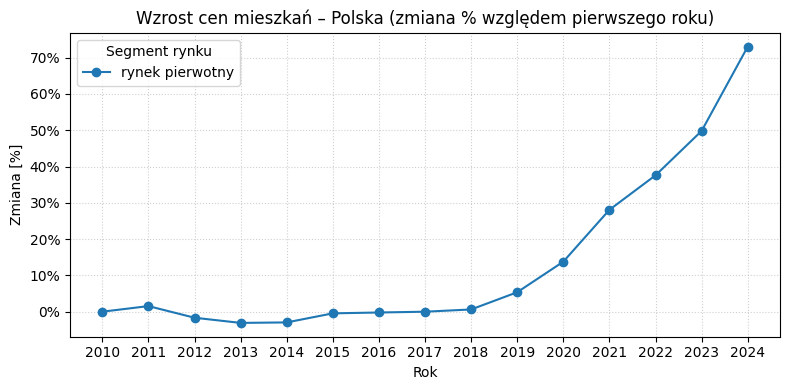

In [268]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import re

# Filtr Polska
mask_polska = dane["Nazwa"].str.contains("POLSKA", case=False, na=False)
polska = dane[mask_polska].copy()
print("Wiersze POLSKA przed czyszczeniem:", len(polska))
print(polska[["Rok", "Wartosc"]].head())

# Agresywne czyszczenie
polska["Rok"] = polska["Rok"].astype(str).str.extract(r"(\d{4})")[0]
polska["Wartosc"] = polska["Wartosc"].astype(str).str.replace(r"[^0-9]", "", regex=True)
polska["Rok"] = pd.to_numeric(polska["Rok"], errors="coerce")
polska["Wartosc"] = pd.to_numeric(polska["Wartosc"], errors="coerce")
polska = polska.dropna(subset=["Rok", "Wartosc"]).sort_values("Rok")
print("Po czyszczeniu wierszy:", len(polska))
print(polska[["Rok", "Wartosc"]].head())

if polska.empty:
    raise ValueError("Brak liczbowych danych dla Polski po czyszczeniu.")

# Zmiana procentowa względem pierwszego roku w każdej serii
pct_list = []
for seg, df_seg in polska.groupby("Transakcje rynkowe"):
    base = df_seg.iloc[0]["Wartosc"]
    pct = df_seg.assign(pct_vs_first=(df_seg["Wartosc"] / base - 1) * 100)
    pct_list.append(pct)
polska_pct = pd.concat(pct_list)

print(polska_pct[["Rok", "Wartosc", "pct_vs_first"]].head())

fig, ax = plt.subplots(figsize=(8, 4))
for segment, df_seg in polska_pct.groupby("Transakcje rynkowe"):
    ax.plot(df_seg["Rok"], df_seg["pct_vs_first"], marker="o", label=segment)

ax.set_title("Wzrost cen mieszkań – Polska (zmiana % względem pierwszego roku)")
ax.set_xlabel("Rok")
ax.set_ylabel("Zmiana [%]")
ax.legend(title="Segment rynku")
ax.grid(True, linestyle=":", alpha=0.6)
ax.set_xticks(sorted(polska_pct["Rok"].unique()))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))

plt.tight_layout()
plt.show()


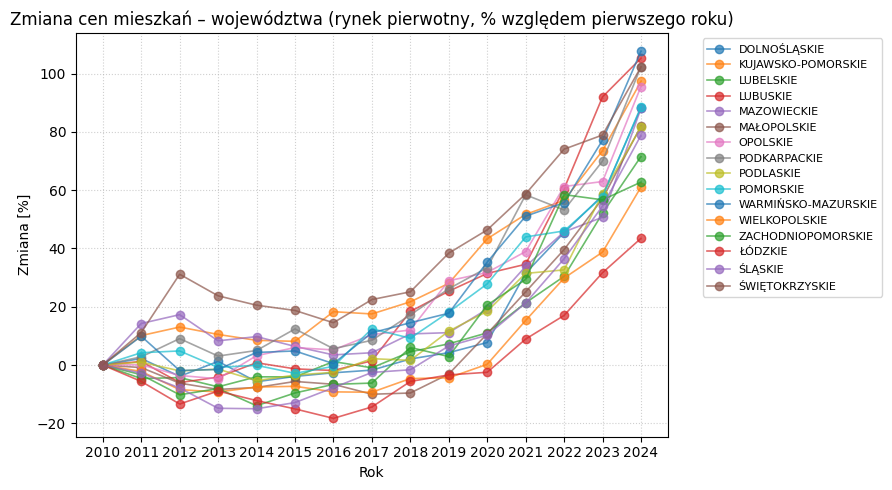

In [269]:
# Wykres: zmiana % względem pierwszego roku dla województw (rynek pierwotny)
import matplotlib.pyplot as plt

voiv = dane.copy()
voiv["Rok"] = pd.to_numeric(voiv["Rok"], errors="coerce")
voiv["Wartosc"] = pd.to_numeric(voiv["Wartosc"], errors="coerce")
voiv = voiv.dropna(subset=["Rok", "Wartosc"])
voiv = voiv[voiv["Transakcje rynkowe"].str.contains("rynek pierwotny", case=False, na=False)]
voiv = voiv[~voiv["Nazwa"].str.contains("POLSKA|powiat|gmina", case=False, na=False)]

pct_rows = []
for name, df in voiv.groupby("Nazwa"):
    df = df.sort_values("Rok")
    base = df.iloc[0]["Wartosc"]
    pct_rows.append(df.assign(pct_vs_first=(df["Wartosc"] / base - 1) * 100))
voiv_pct = pd.concat(pct_rows, ignore_index=True)

fig, ax = plt.subplots(figsize=(9, 5))
for name, df in voiv_pct.groupby("Nazwa"):
    ax.plot(df["Rok"], df["pct_vs_first"], marker="o", linewidth=1.2, alpha=0.7, label=name)

ax.set_title("Zmiana cen mieszkań – województwa (rynek pierwotny, % względem pierwszego roku)")
ax.set_xlabel("Rok")
ax.set_ylabel("Zmiana [%]")
ax.grid(True, linestyle=":", alpha=0.6)
ax.set_xticks(sorted(voiv_pct["Rok"].unique()))
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


In [270]:
# Tabela: CAGR (Polska i województwa, rynek pierwotny)
import pandas as pd

scope = dane.copy()
scope["Rok"] = pd.to_numeric(scope["Rok"], errors="coerce")
scope["Wartosc"] = pd.to_numeric(scope["Wartosc"], errors="coerce")
scope = scope.dropna(subset=["Rok", "Wartosc"])
scope = scope[scope["Transakcje rynkowe"].str.contains("rynek pierwotny", case=False, na=False)]

# Polska + województwa
scope = scope[(scope["Nazwa"].str.contains("POLSKA", case=False, na=False)) | (~scope["Nazwa"].str.contains("powiat|gmina", case=False, na=False))]

rows = []
for name, df in scope.groupby("Nazwa"):
    df = df.sort_values("Rok")
    first = df.iloc[0]["Wartosc"]
    last = df.iloc[-1]["Wartosc"]
    years = df.iloc[-1]["Rok"] - df.iloc[0]["Rok"]
    cagr = (last / first) ** (1 / years) - 1 if years > 0 else float("nan")
    rows.append({"Nazwa": name, "Rok_start": int(df.iloc[0]["Rok"]), "Rok_end": int(df.iloc[-1]["Rok"]), "CAGR": cagr, "Start": first, "Koniec": last})

tab_cagr = pd.DataFrame(rows).sort_values("CAGR", ascending=False)

# Ładny podgląd
pd.options.display.float_format = "{:.2f}".format
print(tab_cagr.head(5))
display(tab_cagr)


                  Nazwa  Rok_start  Rok_end  CAGR     Start    Koniec
11  WARMIŃSKO-MAZURSKIE       2010     2024  0.05 206177.00 428176.00
3              LUBUSKIE       2010     2024  0.05 177963.00 365272.00
7          PODKARPACKIE       2010     2024  0.05 207634.00 420127.00
16       ŚWIĘTOKRZYSKIE       2010     2024  0.05 205826.00 416320.00
1    KUJAWSKO-POMORSKIE       2010     2024  0.05 201776.00 398135.00


Nazwa  Rok_start  Rok_end  CAGR     Start    Koniec
11  WARMIŃSKO-MAZURSKIE       2010     2024  0.05 206177.00 428176.00
3              LUBUSKIE       2010     2024  0.05 177963.00 365272.00
7          PODKARPACKIE       2010     2024  0.05 207634.00 420127.00
16       ŚWIĘTOKRZYSKIE       2010     2024  0.05 205826.00 416320.00
1    KUJAWSKO-POMORSKIE       2010     2024  0.05 201776.00 398135.00
6              OPOLSKIE       2010     2024  0.05 215586.00 421586.00
10            POMORSKIE       2010     2024  0.05 305608.00 576509.00
0          DOLNOŚLĄSKIE       2010     2024  0.05 312729.00 588538.00
4           MAZOWIECKIE       2010     2024  0.05 374545.00 704484.00
5           MAŁOPOLSKIE       2010     2024  0.04 359656.00 654439.00
8             PODLASKIE       2010     2024  0.04 232239.00 421813.00
15              ŚLĄSKIE       2010     2024  0.04 246559.00 440896.00
9                POLSKA       2010     2024  0.04 309936.00 536279.00
2             LUBELSKIE       2010     2024  0.04 268921.00 461313.00
13   ZACHODNIOPOMORSKIE       2010     2024  0.04 286647.00 466532.00
12        WIELKOPOLSKIE       2010     2024  0.03 295967.00 476695.00
14              ŁÓDZKIE       2010     2024  0.03 294620.00 422670.00

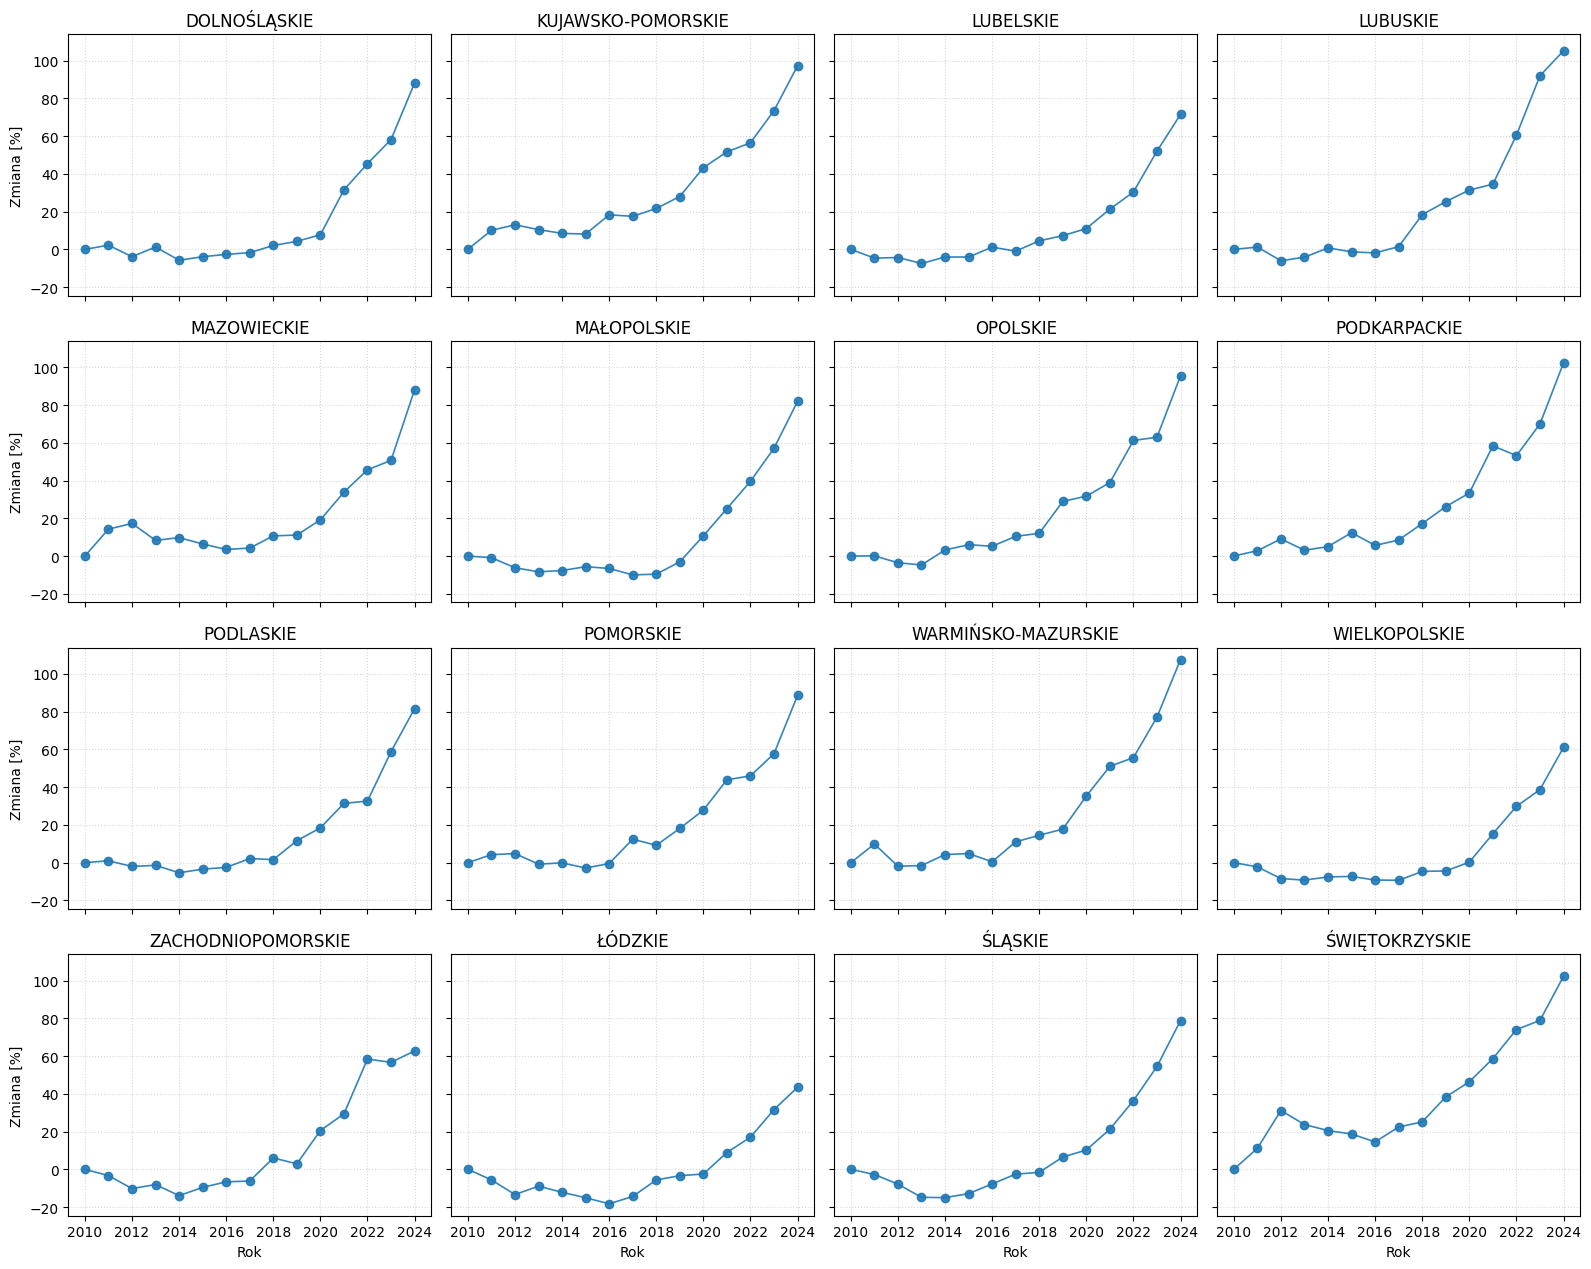

In [271]:
# Siatka wykresów: zmiana % względem pierwszego roku dla każdego województwa (rynek pierwotny)
import math
import matplotlib.pyplot as plt

voiv = dane.copy()
voiv["Rok"] = pd.to_numeric(voiv["Rok"], errors="coerce")
voiv["Wartosc"] = pd.to_numeric(voiv["Wartosc"], errors="coerce")
voiv = voiv.dropna(subset=["Rok", "Wartosc"])
voiv = voiv[voiv["Transakcje rynkowe"].str.contains("rynek pierwotny", case=False, na=False)]
voiv = voiv[~voiv["Nazwa"].str.contains("POLSKA|powiat|gmina", case=False, na=False)]

pct_rows = []
for name, df in voiv.groupby("Nazwa"):
    df = df.sort_values("Rok")
    base = df.iloc[0]["Wartosc"]
    pct_rows.append(df.assign(pct_vs_first=(df["Wartosc"] / base - 1) * 100))
voiv_pct = pd.concat(pct_rows, ignore_index=True)

names = sorted(voiv_pct["Nazwa"].unique())
n = len(names)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(16, 3.2 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, name in enumerate(names):
    ax = axes[i]
    df = voiv_pct[voiv_pct["Nazwa"] == name]
    ax.plot(df["Rok"], df["pct_vs_first"], marker="o", linewidth=1.2, alpha=0.9)
    ax.set_title(name)
    ax.grid(True, linestyle=":", alpha=0.5)
    if i % cols == 0:
        ax.set_ylabel("Zmiana [%]")
    if i // cols == rows - 1:
        ax.set_xlabel("Rok")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [272]:
# Funkcja: pojedynczy wykres % dla wybranego województwa (rynek pierwotny)
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def plot_voiv_percent(name, segment="rynek pierwotny"):
    target = name.strip().upper()
    df = dane.copy()
    df = df[df["Transakcje rynkowe"].str.contains(segment, case=False, na=False)]
    df["Rok"] = pd.to_numeric(df["Rok"], errors="coerce")
    df["Wartosc"] = pd.to_numeric(df["Wartosc"], errors="coerce")
    df = df.dropna(subset=["Rok", "Wartosc"])
    df["_nazwa"] = df["Nazwa"].str.strip().str.upper()
    df = df[df["_nazwa"] == target]
    df = df[~df["_nazwa"].str.contains("POLSKA|POWIAT|GMINA", case=False, na=False)]
    if df.empty:
        raise ValueError(f"Brak danych dla: {name}")
    df = df.sort_values("Rok")
    base = df.iloc[0]["Wartosc"]
    df = df.assign(pct_vs_first=(df["Wartosc"] / base - 1) * 100)

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(df["Rok"], df["pct_vs_first"], marker="o", linewidth=1.5)
    ax.set_title(f"{df.iloc[0]['Nazwa']} – zmiana % względem pierwszego roku")
    ax.set_xlabel("Rok")
    ax.set_ylabel("Zmiana [%]")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.set_xticks(sorted(df["Rok"].unique()))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))
    plt.tight_layout()
    plt.show()


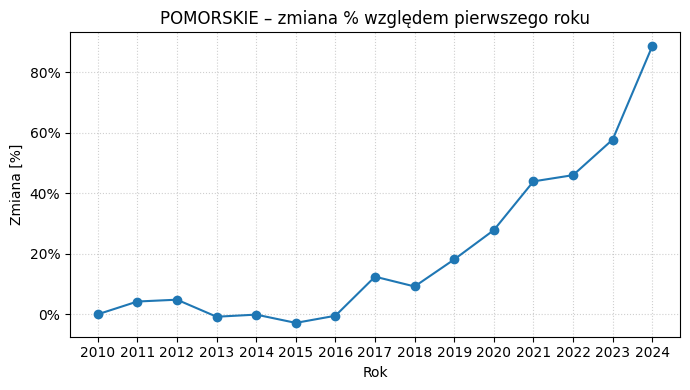

In [273]:
# Pomorskie – zmiana %
plot_voiv_percent("POMORSKIE")


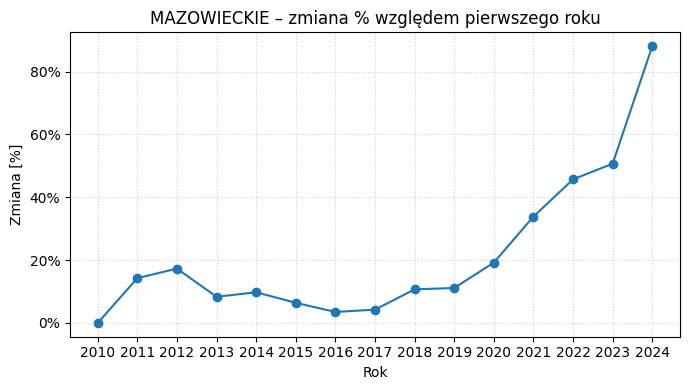

In [274]:
# Mazowieckie – zmiana %
plot_voiv_percent("MAZOWIECKIE")


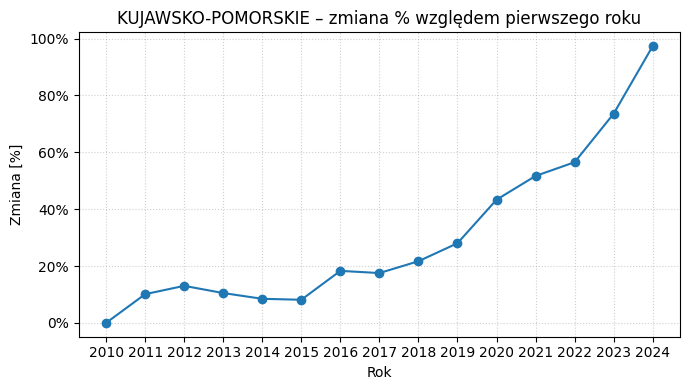

In [275]:
# Kujawsko-Pomorskie – zmiana %
plot_voiv_percent("KUJAWSKO-POMORSKIE")


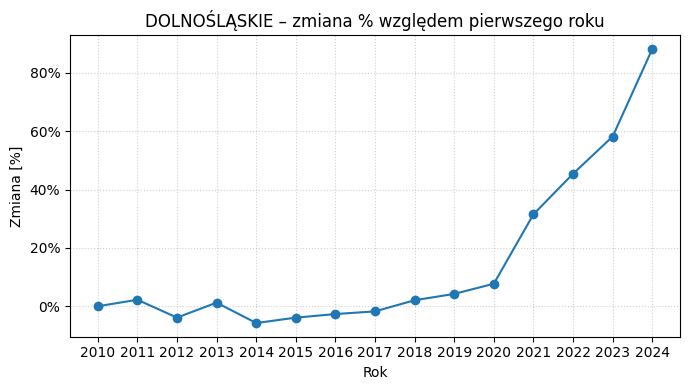

In [276]:
# Dolnośląskie – zmiana %
plot_voiv_percent("DOLNOŚLĄSKIE")


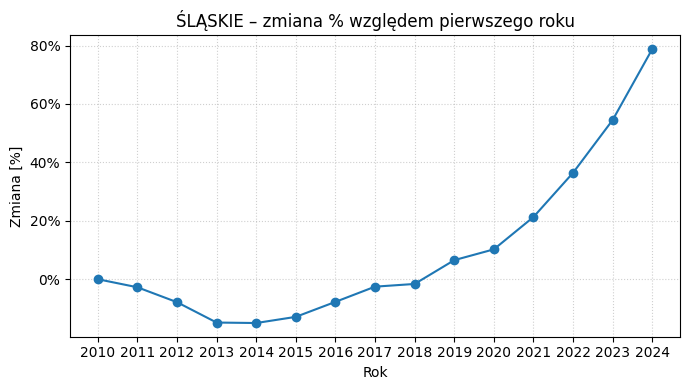

In [277]:
# Śląskie – zmiana %
plot_voiv_percent("ŚLĄSKIE")


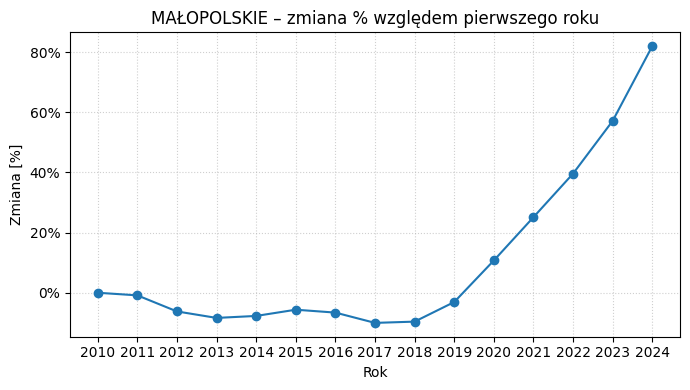

In [278]:
# Małopolskie – zmiana %
plot_voiv_percent("MAŁOPOLSKIE")


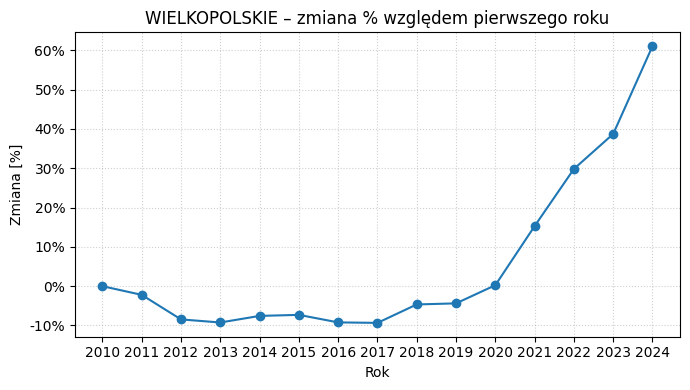

In [279]:
# Wielkopolskie – zmiana %
plot_voiv_percent("WIELKOPOLSKIE")


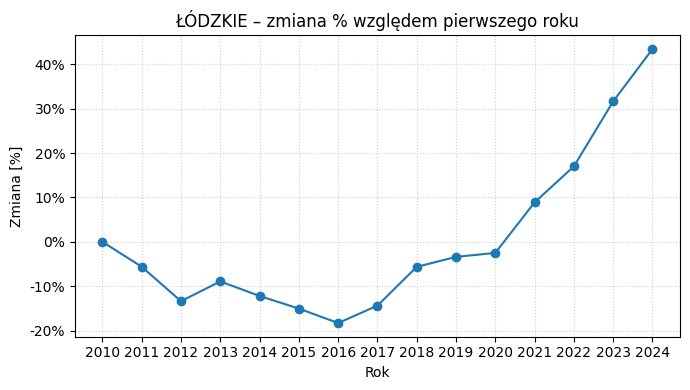

In [280]:
# Łódzkie – zmiana %
plot_voiv_percent("ŁÓDZKIE")


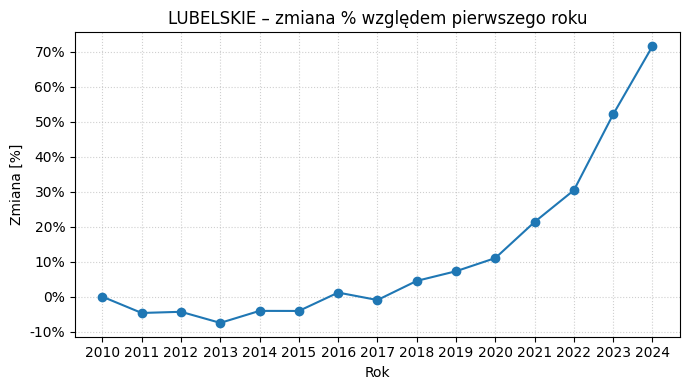

In [281]:
# Lubelskie – zmiana %
plot_voiv_percent("LUBELSKIE")


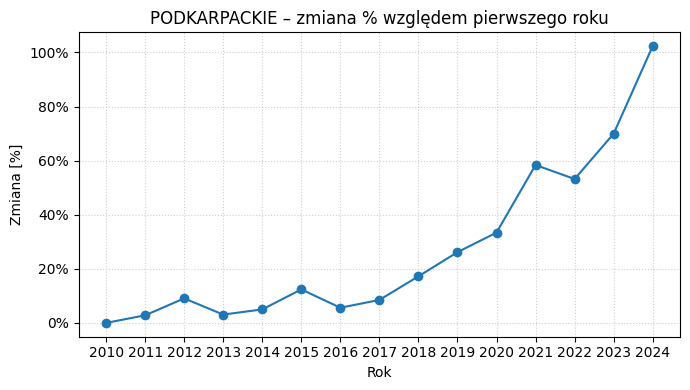

In [282]:
# Podkarpackie – zmiana %
plot_voiv_percent("PODKARPACKIE")


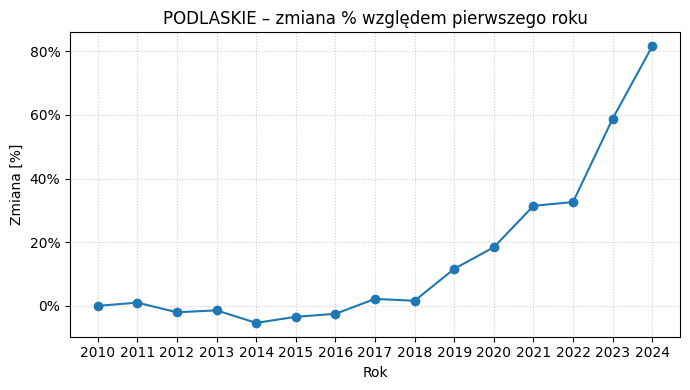

In [283]:
# Podlaskie – zmiana %
plot_voiv_percent("PODLASKIE")


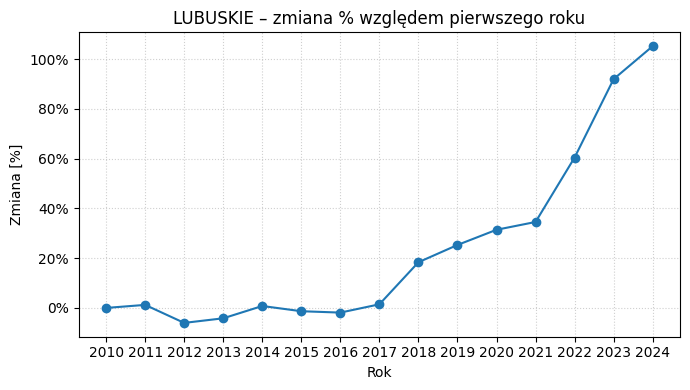

In [284]:
# Lubuskie – zmiana %
plot_voiv_percent("LUBUSKIE")


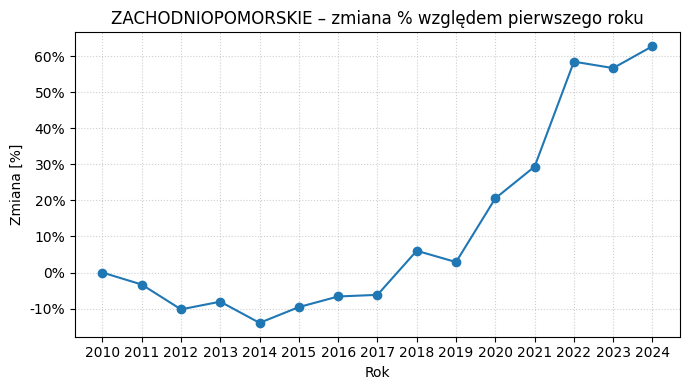

In [285]:
# Zachodniopomorskie – zmiana %
plot_voiv_percent("ZACHODNIOPOMORSKIE")


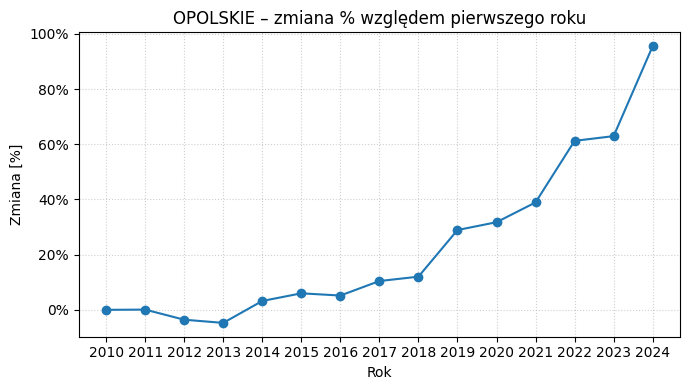

In [286]:
# Opolskie – zmiana %
plot_voiv_percent("OPOLSKIE")


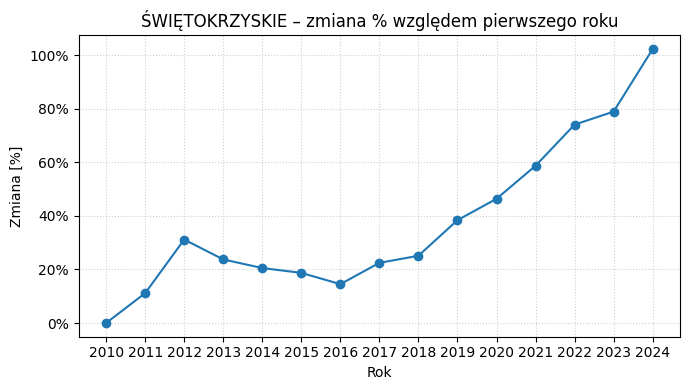

In [287]:
# Świętokrzyskie – zmiana %
plot_voiv_percent("ŚWIĘTOKRZYSKIE")


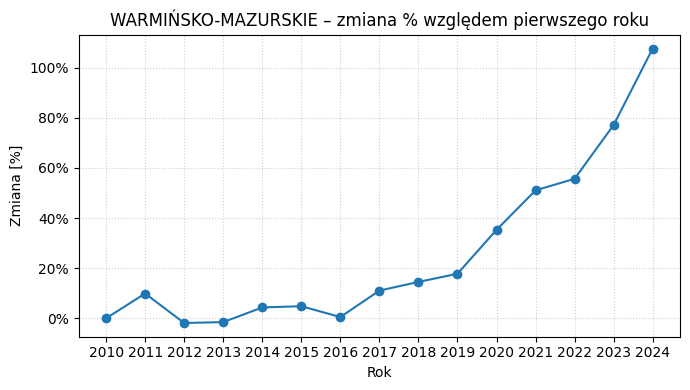

In [288]:
# Warmińsko-Mazurskie – zmiana %
plot_voiv_percent("WARMIŃSKO-MAZURSKIE")


In [289]:
# Przygotowanie danych dla powiatów - filtowanie po kodzie (XX-Y00)
import pandas as pd
import re

powiat = dane.copy()
powiat["Rok"] = pd.to_numeric(powiat["Rok"], errors="coerce")
powiat["Wartosc"] = pd.to_numeric(powiat["Wartosc"], errors="coerce")
powiat = powiat.dropna(subset=["Rok", "Wartosc"])
powiat = powiat[powiat["Transakcje rynkowe"].str.contains("rynek pierwotny", case=False, na=False)]

# Powiaty mają kody XX-Y00
def is_powiat_code(kod):
    if pd.isna(kod):
        return False
    kod_str = str(kod).strip()
    match = re.match(r"(\d{2})-(\d{3})", kod_str)
    if match:
        last_two_digits = int(match.group(2)) % 100
        return last_two_digits == 0 and int(match.group(2)) > 0  # Nie 00-000
    return False

powiat["_is_powiat"] = powiat["Kod"].apply(is_powiat_code)
powiat = powiat[powiat["_is_powiat"] == True]

# Usuń POLSKA
powiat = powiat[~powiat["Nazwa"].str.contains("POLSKA", case=False, na=False)]

# WAŻNE: Usuń wartości zerowe
powiat = powiat[powiat["Wartosc"] > 0]

print(f"Liczba unikalnych powiatów: {powiat['Nazwa'].nunique()}")
print(f"Liczba wierszy danych: {len(powiat)}")
print(f"\nPrzykład nazw i kodów powiatów:\n")
print(powiat[["Nazwa", "Kod"]].drop_duplicates().head(15))


Liczba unikalnych powiatów: 102
Liczba wierszy danych: 1119

Przykład nazw i kodów powiatów:

                     Nazwa     Kod
33    Powiat bolesławiecki  20-100
45   Powiat dzierżoniowski  20-200
60        Powiat głogowski  20-300
82         Powiat górowski  20-400
97         Powiat jaworski  20-500
105      Powiat karkonoski  20-600
120  Powiat kamiennogórski  20-700
135         Powiat kłodzki  20-800
152        Powiat legnicki  20-900
180        Powiat lubiński  21-100
202        Powiat lwówecki  21-200
210         Powiat milicki  21-300
225       Powiat oleśnicki  21-400
241         Powiat oławski  21-500
255      Powiat polkowicki  21-600


In [290]:
# Tabela CAGR dla powiatów (top 16)
import pandas as pd

# Użyj powiat_data po usunięciu zer
powiat_cagr_rows = []
for name, df in powiat_data.groupby("Nazwa"):
    df_sorted = df.sort_values("Rok")
    if len(df_sorted) < 2:
        continue
    first = df_sorted.iloc[0]["Wartosc"]
    last = df_sorted.iloc[-1]["Wartosc"]
    years = df_sorted.iloc[-1]["Rok"] - df_sorted.iloc[0]["Rok"]
    if years <= 0 or first == 0:
        continue
    cagr = (last / first) ** (1 / years) - 1
    powiat_cagr_rows.append({
        "Nazwa": name,
        "Rok_start": int(df_sorted.iloc[0]["Rok"]),
        "Rok_end": int(df_sorted.iloc[-1]["Rok"]),
        "CAGR": cagr,
        "Start": first,
        "Koniec": last
    })

tab_powiat_cagr = pd.DataFrame(powiat_cagr_rows).sort_values("CAGR", ascending=False)
pd.options.display.float_format = "{:.2f}".format
print(f"Top 16 powiatów - najwyższy wzrost CAGR:\n")
display(tab_powiat_cagr.head(16))


Top 16 powiatów - najwyższy wzrost CAGR:



Nazwa  Rok_start  Rok_end  CAGR     Start    Koniec
71       Powiat szydłowiecki       2017     2023  0.25  78350.00 301349.00
15           Powiat jaworski       2017     2024  0.17 129150.00 391166.00
74       Powiat tarnobrzeski       2018     2024  0.16 214143.00 511488.00
90        Powiat złotoryjski       2016     2024  0.15 131956.00 409095.00
82          Powiat wschowski       2016     2024  0.15 170641.00 506364.00
1             Powiat bialski       2018     2024  0.11 170764.00 316810.00
23           Powiat legnicki       2012     2024  0.10 150800.00 485470.00
72         Powiat sępoleński       2016     2024  0.10 166378.00 356534.00
83          Powiat wąbrzeski       2013     2024  0.09 110037.00 289527.00
28  Powiat m. Biała Podlaska       2014     2024  0.09 118167.00 282956.00
45         Powiat mogileński       2015     2024  0.09 132000.00 286395.00
87        Powiat zgorzelecki       2017     2024  0.09 201075.00 363902.00
77          Powiat tucholski       2014     2024  0.08 136000.00 304576.00
63          Powiat radzyński       2014     2023  0.08 148326.00 304354.00
75        Powiat tomaszowski       2010     2023  0.08 167927.00 449000.00
44       Powiat międzyrzecki       2011     2024  0.08 167425.00 441660.00

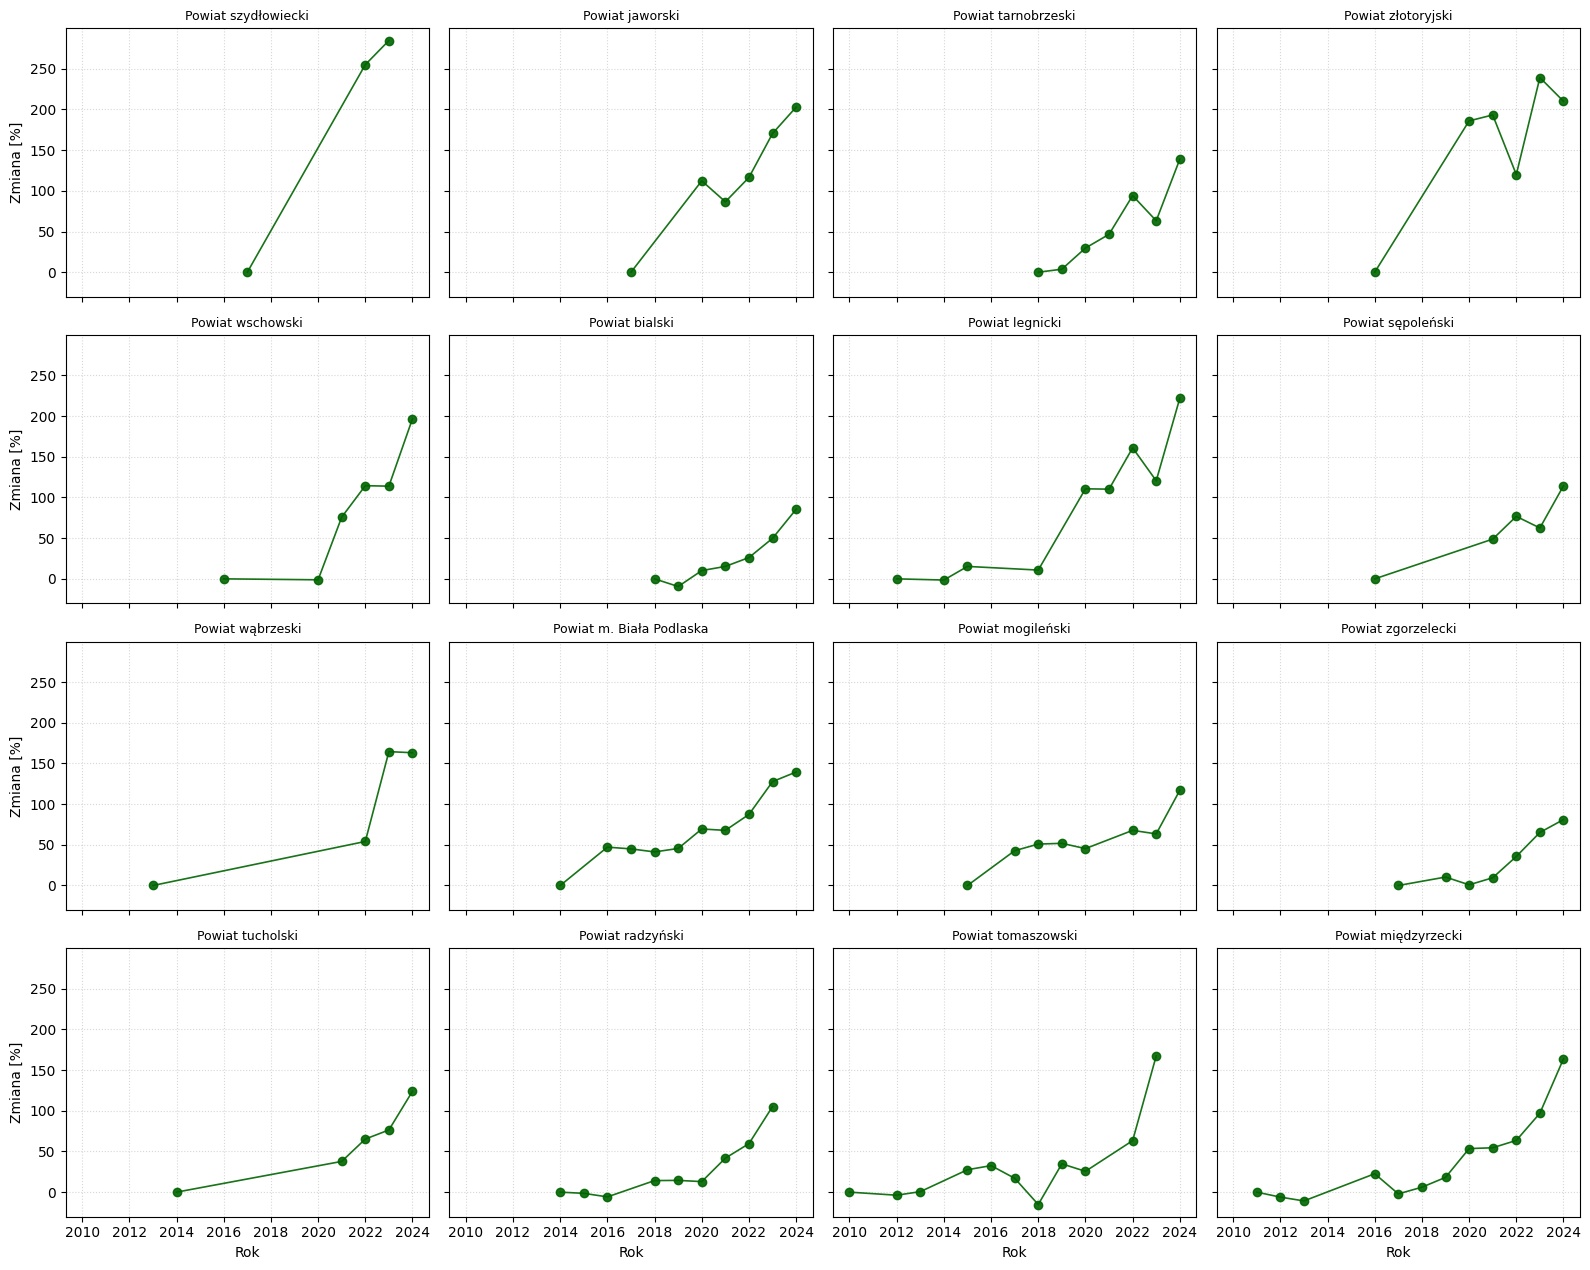

In [291]:
# Siatka wykresów: top 16 powiatów (najwyższy wzrost)
import math
import matplotlib.pyplot as plt

powiat_data = dane.copy()
powiat_data["Rok"] = pd.to_numeric(powiat_data["Rok"], errors="coerce")
powiat_data["Wartosc"] = pd.to_numeric(powiat_data["Wartosc"], errors="coerce")
powiat_data = powiat_data.dropna(subset=["Rok", "Wartosc"])
powiat_data = powiat_data[powiat_data["Transakcje rynkowe"].str.contains("rynek pierwotny", case=False, na=False)]
powiat_data["_is_powiat"] = powiat_data["Kod"].apply(is_powiat_code)
powiat_data = powiat_data[powiat_data["_is_powiat"] == True]
powiat_data = powiat_data[~powiat_data["Nazwa"].str.contains("POLSKA", case=False, na=False)]

# WAŻNE: Usuń wiersze z Wartosc == 0
powiat_data = powiat_data[powiat_data["Wartosc"] > 0]

pct_rows_powiat = []
for name, df in powiat_data.groupby("Nazwa"):
    df = df.sort_values("Rok")
    if len(df) < 2:
        continue
    base = df.iloc[0]["Wartosc"]
    pct_rows_powiat.append(df.assign(pct_vs_first=(df["Wartosc"] / base - 1) * 100))
powiat_pct = pd.concat(pct_rows_powiat, ignore_index=True)

# Pobierz top 16 powiatów po CAGR
top_powiaty_names = tab_powiat_cagr.head(16)["Nazwa"].tolist()
powiat_pct_top = powiat_pct[powiat_pct["Nazwa"].isin(top_powiaty_names)]

cols = 4
rows = math.ceil(len(top_powiaty_names) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(16, 3.2 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, name in enumerate(top_powiaty_names):
    ax = axes[i]
    df = powiat_pct_top[powiat_pct_top["Nazwa"] == name]
    ax.plot(df["Rok"], df["pct_vs_first"], marker="o", linewidth=1.2, alpha=0.9, color="darkgreen")
    ax.set_title(name, fontsize=9)
    ax.grid(True, linestyle=":", alpha=0.5)
    if i % cols == 0:
        ax.set_ylabel("Zmiana [%]")
    if i // cols == rows - 1:
        ax.set_xlabel("Rok")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


**Uwaga:** Powyższa siatka pokazuje 16 powiatów z największym wzrostem CAGR. Dane powiatowe są dostępne w zbiorze danych (103 powiaty), ale każdy powiat ma zazwyczaj tylko pojedyncze wartości rocznie, co czyni wykresy indywidualne mało czytelne. Siatka wspólna (grid) pozwala porównać trendy między powiatami.

In [292]:
# DEBUG: jakie wartości Transakcje rynkowe dla powiatów?
import re

powiat_debug = dane.copy()
powiat_debug["Rok"] = pd.to_numeric(powiat_debug["Rok"], errors="coerce")
powiat_debug["Wartosc"] = pd.to_numeric(powiat_debug["Wartosc"], errors="coerce")
powiat_debug = powiat_debug.dropna(subset=["Rok", "Wartosc"])

def is_powiat_code(kod):
    if pd.isna(kod):
        return False
    kod_str = str(kod).strip()
    match = re.match(r"(\d{2})-(\d{3})", kod_str)
    if match:
        last_two_digits = int(match.group(2)) % 100
        return last_two_digits == 0 and int(match.group(2)) > 0
    return False

powiat_debug["_is_powiat"] = powiat_debug["Kod"].apply(is_powiat_code)
powiat_debug = powiat_debug[powiat_debug["_is_powiat"] == True]
powiat_debug = powiat_debug[~powiat_debug["Nazwa"].str.contains("POLSKA", case=False, na=False)]

print("Wszystkie wartości 'Transakcje rynkowe' dla powiatów:")
print(powiat_debug["Transakcje rynkowe"].unique())
print(f"\nIlość wierszy dla każdego typu:\n")
print(powiat_debug["Transakcje rynkowe"].value_counts())

# Pokażmy przykład danych dla pierwszego powiatu
first_powiat = powiat_debug["Nazwa"].unique()[0]
print(f"\nPrzykład danych dla {first_powiat}:")
print(powiat_debug[powiat_debug["Nazwa"] == first_powiat][["Rok", "Wartosc", "Transakcje rynkowe"]].head(10))


Wszystkie wartości 'Transakcje rynkowe' dla powiatów:
['rynek pierwotny']

Ilość wierszy dla każdego typu:

Transakcje rynkowe
rynek pierwotny    1557
Name: count, dtype: int64

Przykład danych dla Powiat bolesławiecki:
     Rok   Wartosc Transakcje rynkowe
30  2010      0.00    rynek pierwotny
31  2011      0.00    rynek pierwotny
32  2012      0.00    rynek pierwotny
33  2013 203906.00    rynek pierwotny
34  2014 146100.00    rynek pierwotny
35  2015 197069.00    rynek pierwotny
36  2016 215579.00    rynek pierwotny
37  2017 180600.00    rynek pierwotny
38  2018 225266.00    rynek pierwotny
39  2019 259905.00    rynek pierwotny


In [293]:
# Funkcja: pojedynczy wykres % dla wybranego powiatu (rynek pierwotny)
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_powiat_percent(name, segment="rynek pierwotny"):
    target = name.strip().lower()
    df = dane.copy()
    df = df[df["Transakcje rynkowe"].str.contains(segment, case=False, na=False)]
    df["Rok"] = pd.to_numeric(df["Rok"], errors="coerce")
    df["Wartosc"] = pd.to_numeric(df["Wartosc"], errors="coerce")
    df = df.dropna(subset=["Rok", "Wartosc"])
    df = df[df["Wartosc"] > 0]  # Usuń zera
    df["_nazwa"] = df["Nazwa"].str.strip().str.lower()
    df = df[df["_nazwa"] == target]
    if df.empty:
        raise ValueError(f"Brak danych dla: {name}")
    df = df.sort_values("Rok")
    base = df.iloc[0]["Wartosc"]
    df = df.assign(pct_vs_first=(df["Wartosc"] / base - 1) * 100)

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(df["Rok"], df["pct_vs_first"], marker="o", linewidth=1.5, color="darkgreen")
    ax.set_title(f"{df.iloc[0]['Nazwa']} – zmiana % względem pierwszego roku")
    ax.set_xlabel("Rok")
    ax.set_ylabel("Zmiana [%]")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.set_xticks(sorted(df["Rok"].unique()))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))
    plt.tight_layout()
    plt.show()


In [294]:
# Analiza jakości danych dla powiatów - ile lat danych ma każdy powiat
print("ANALIZA JAKOŚCI DANYCH DLA POWIATÓW")
print("=" * 80)

data_quality = []
for powiat_name in sorted(powiat["Nazwa"].unique()):
    df_p = powiat[powiat["Nazwa"] == powiat_name].copy()
    df_p = df_p.sort_values("Rok")
    num_years = len(df_p)
    year_range = f"{int(df_p['Rok'].min())}-{int(df_p['Rok'].max())}"
    span = int(df_p['Rok'].max()) - int(df_p['Rok'].min())
    
    data_quality.append({
        "Powiat": powiat_name,
        "Liczba lat": num_years,
        "Zakres": year_range,
        "Rozpęd": span,
        "Status": "✓ OK" if num_years >= 3 else "✗ ZBYT MAŁO DANYCH"
    })

quality_df = pd.DataFrame(data_quality)

# Podsumowanie
ok_count = (quality_df["Status"] == "✓ OK").sum()
bad_count = (quality_df["Status"] == "✗ ZBYT MAŁO DANYCH").sum()

print(f"\n✓ Powiaty DO ANALIZY (≥3 punkty danych): {ok_count}")
print(f"✗ Powiaty WYKLUCZONE (< 3 punkty danych): {bad_count}")
print(f"\nPowiaty WYKLUCZONE (uzasadnienie: zbyt mało punktów danych):")
print("=" * 80)
excluded = quality_df[quality_df["Status"] == "✗ ZBYT MAŁO DANYCH"]
for idx, row in excluded.iterrows():
    print(f"  • {row['Powiat']:40s} | {row['Liczba lat']} punkt(y) danych ({row['Zakres']})")

# Zapisz listę dobrych powiatów
good_powiats = quality_df[quality_df["Status"] == "✓ OK"]["Powiat"].tolist()
print(f"\n\nDobra lista powiatów ({len(good_powiats)} powiatów):")
print("=" * 80)
for i, p in enumerate(good_powiats, 1):
    num_years = quality_df[quality_df["Powiat"] == p]["Liczba lat"].values[0]
    year_range = quality_df[quality_df["Powiat"] == p]["Zakres"].values[0]
    print(f"{i:3d}. {p:40s} | {num_years} lat ({year_range})")

ANALIZA JAKOŚCI DANYCH DLA POWIATÓW

✓ Powiaty DO ANALIZY (≥3 punkty danych): 98
✗ Powiaty WYKLUCZONE (< 3 punkty danych): 4

Powiaty WYKLUCZONE (uzasadnienie: zbyt mało punktów danych):
  • Powiat grudziądzki                       | 1 punkt(y) danych (2023-2023)
  • Powiat lwówecki                          | 1 punkt(y) danych (2017-2017)
  • Powiat prudnicki                         | 2 punkt(y) danych (2022-2024)
  • Powiat łosicki                           | 2 punkt(y) danych (2013-2023)


Dobra lista powiatów (98 powiatów):
  1. Powiat aleksandrowski                    | 15 lat (2010-2024)
  2. Powiat bialski                           | 7 lat (2018-2024)
  3. Powiat biłgorajski                       | 12 lat (2011-2024)
  4. Powiat bolesławiecki                     | 12 lat (2013-2024)
  5. Powiat brodnicki                         | 15 lat (2010-2024)
  6. Powiat bydgoski                          | 15 lat (2010-2024)
  7. Powiat chełmiński                        | 6 lat (2010-2024)


## Wykresy indywidualne powiatów – TYLKO powiaty z wystarczającą ilością danych

**Kryterium:** Minimalnie 3 punkty danych (lata) dla wiarygodnej analizy trendu.
**Wyeliminowane:** Powiaty z pojedynczym rokiem lub 2-letnimi danymi – brak możliwości oceny trendu.



Generowanie 98 wykresów dla powiatów z wystarczającą ilością danych...


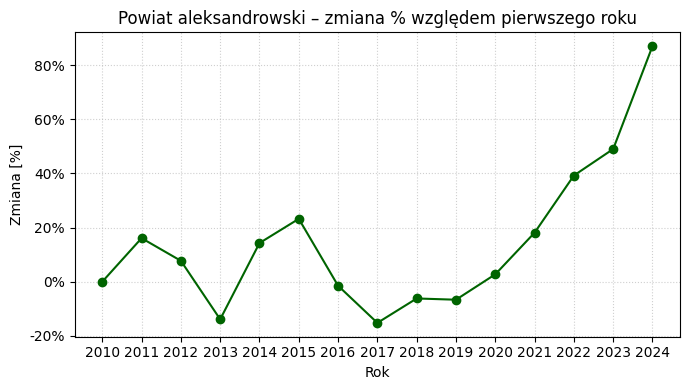

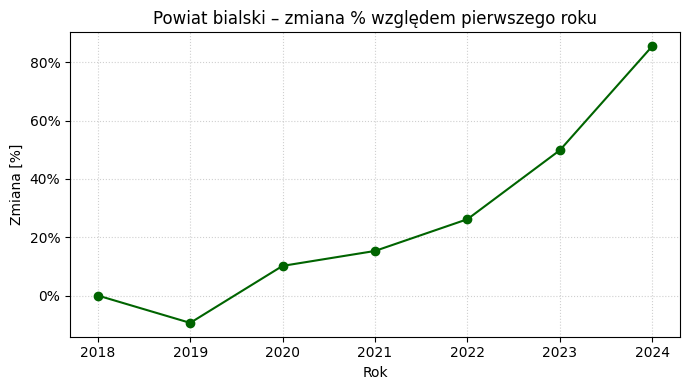

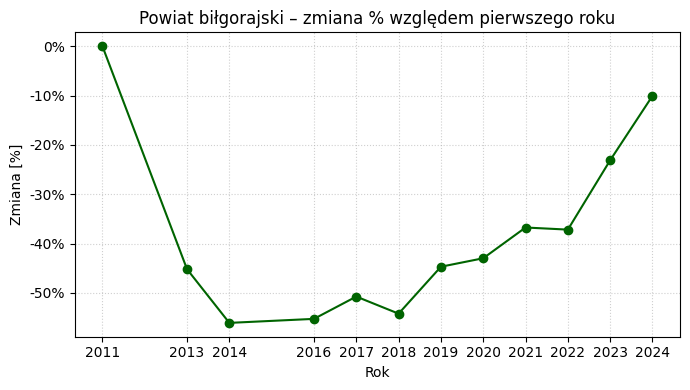

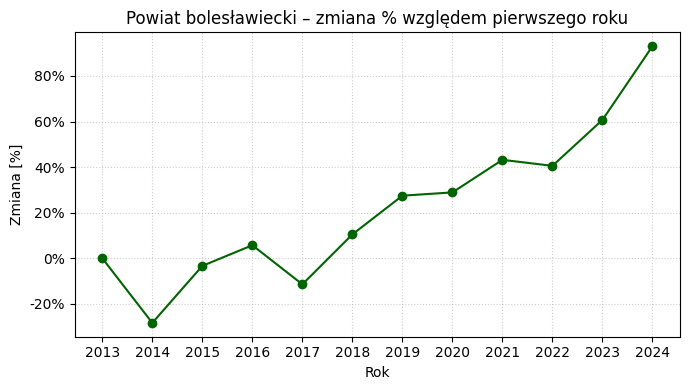

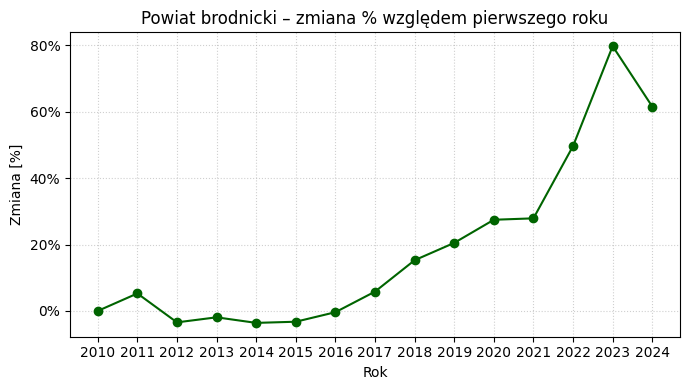

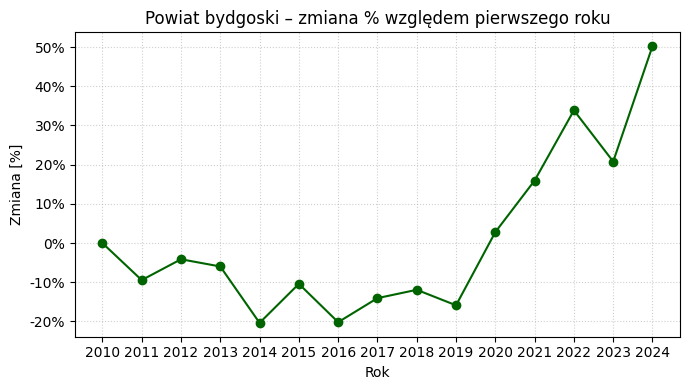

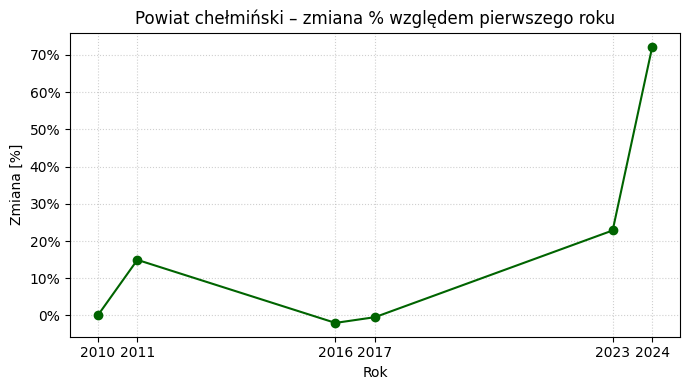

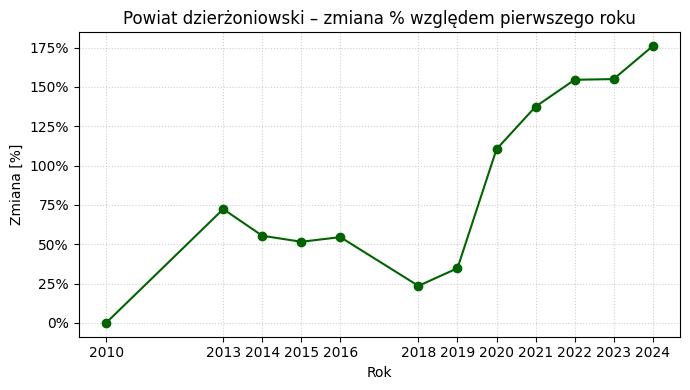

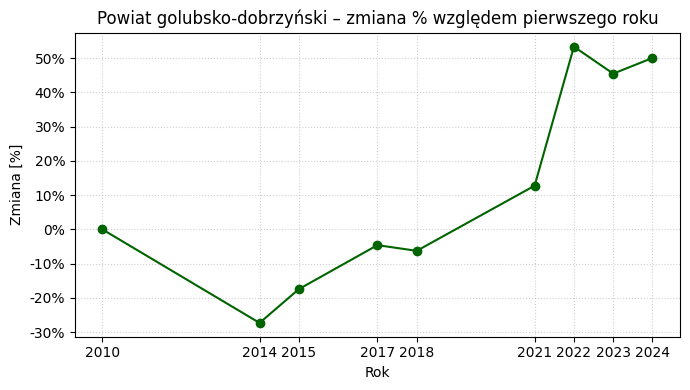

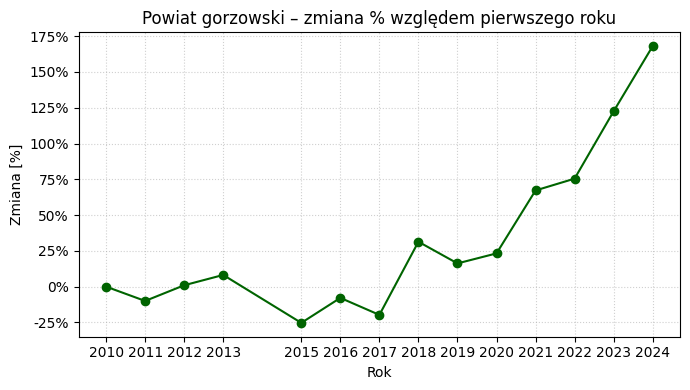

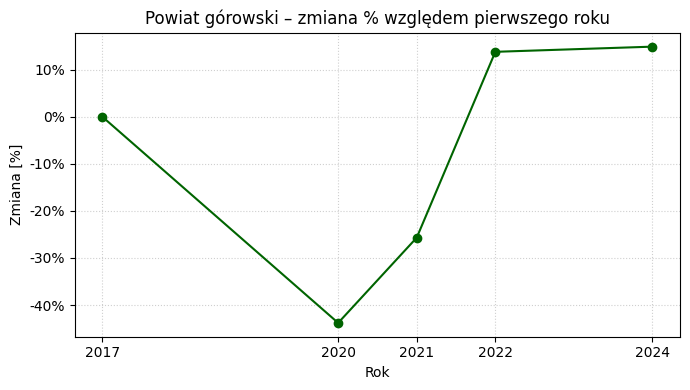

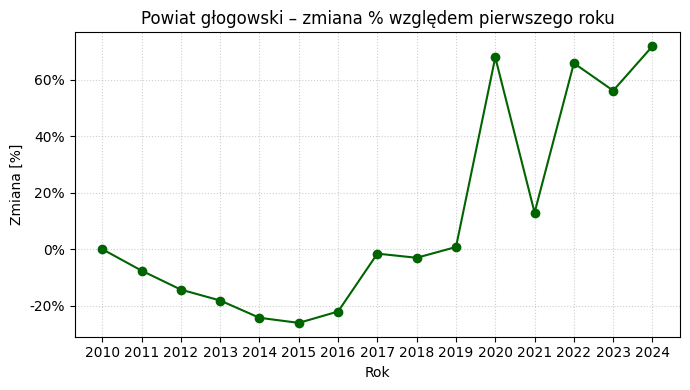

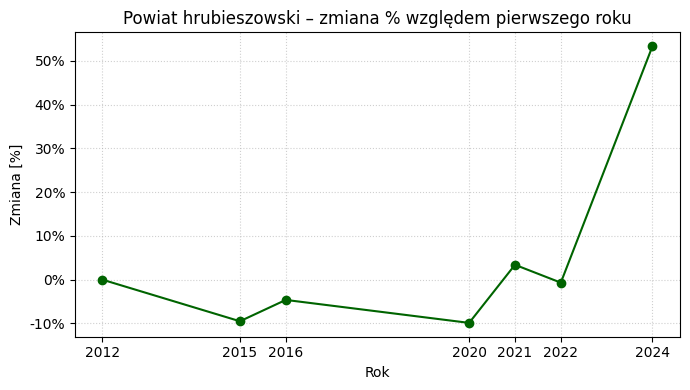

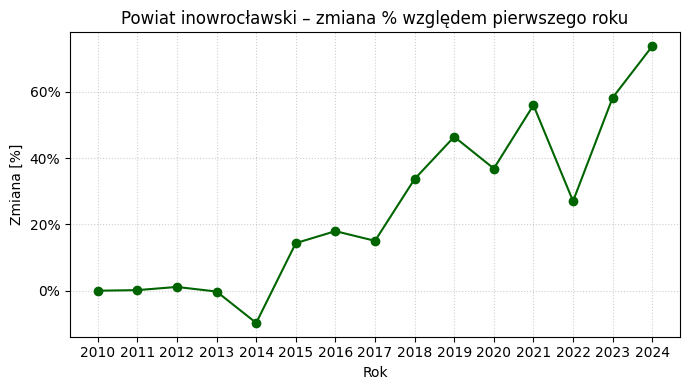

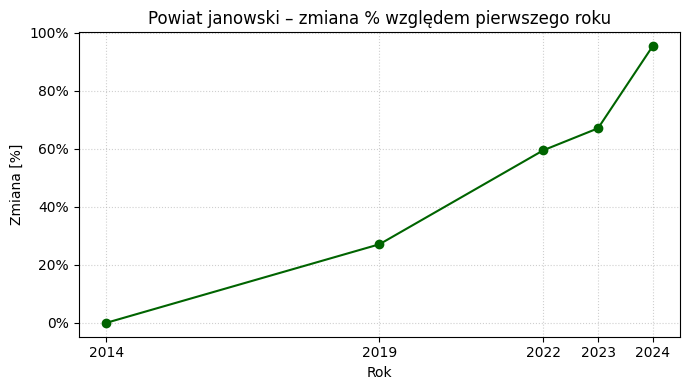

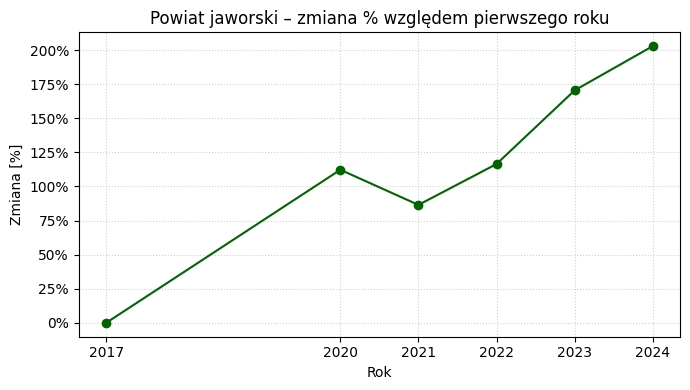

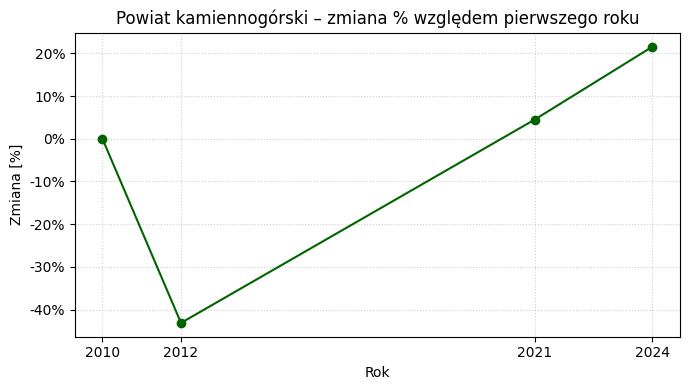

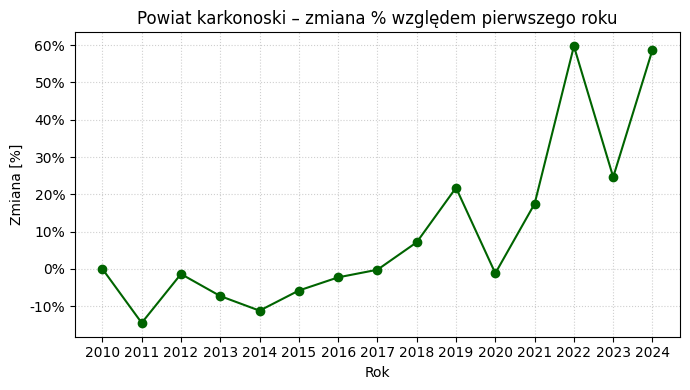

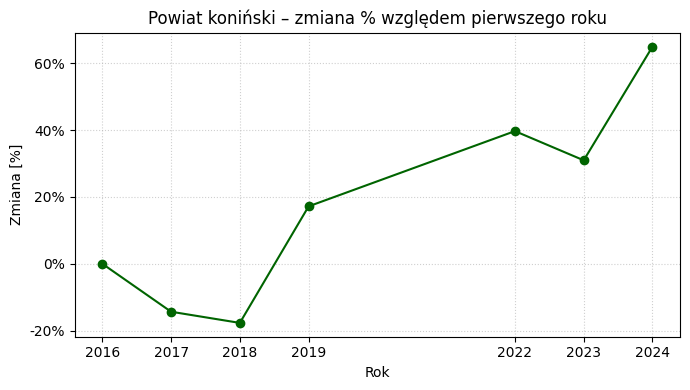

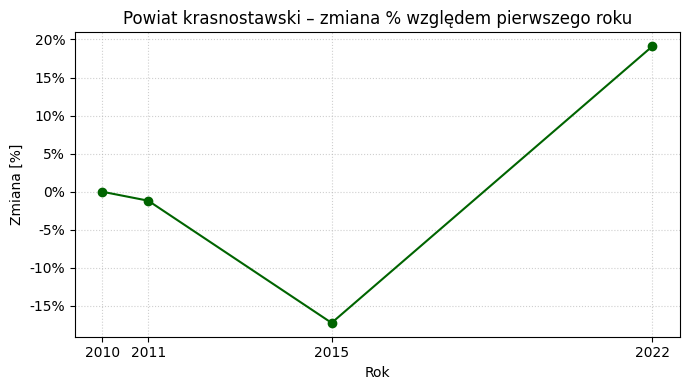

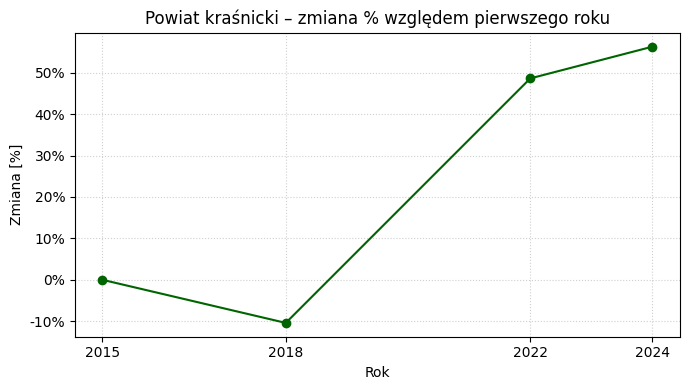

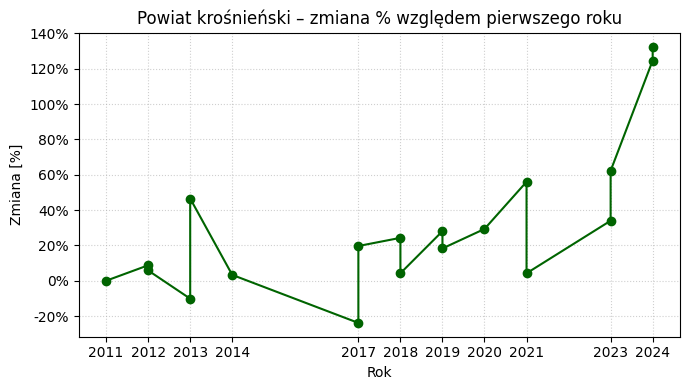

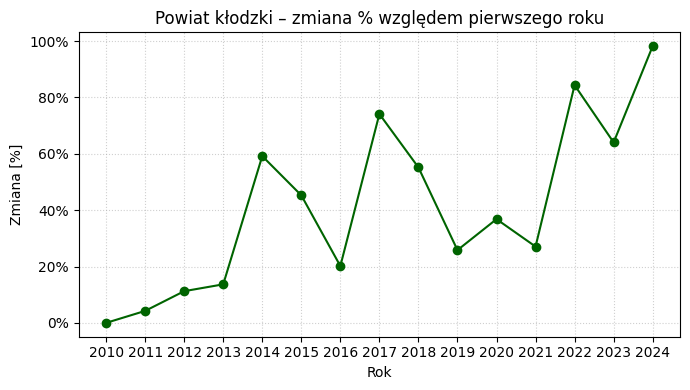

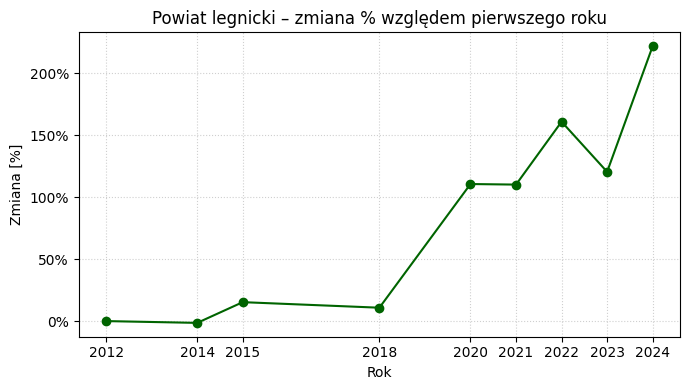

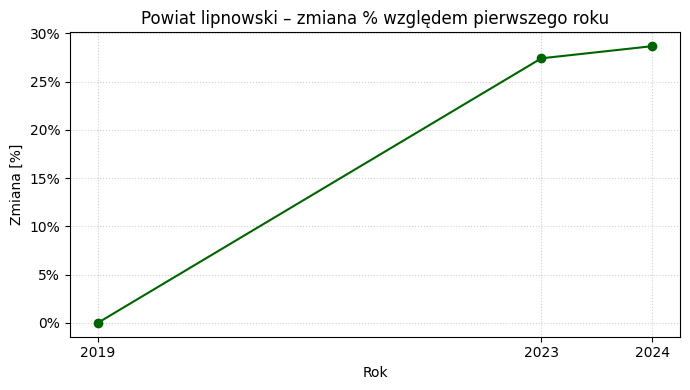

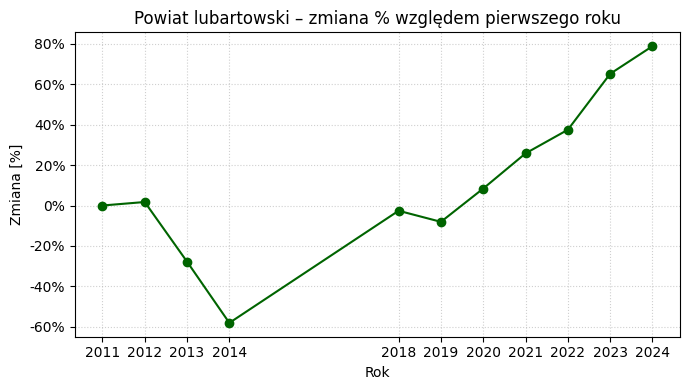

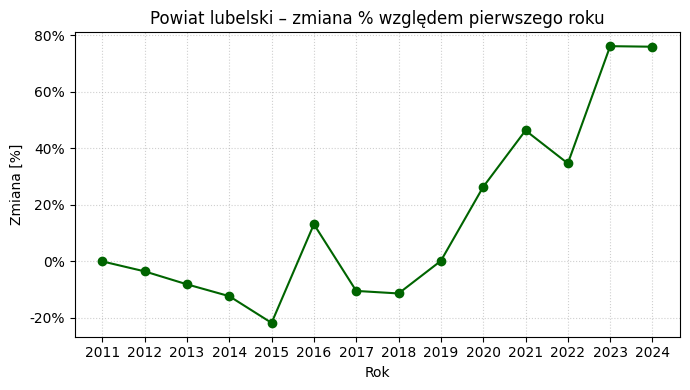

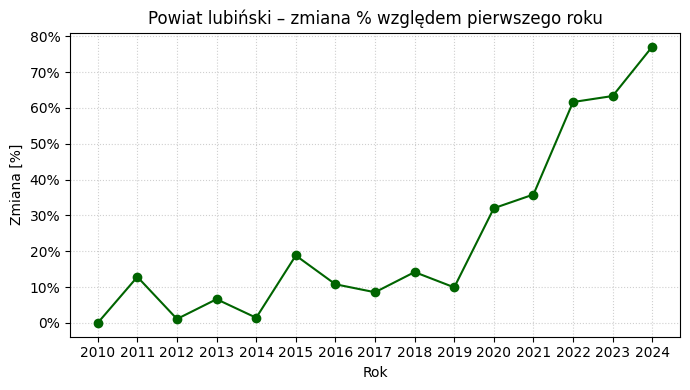

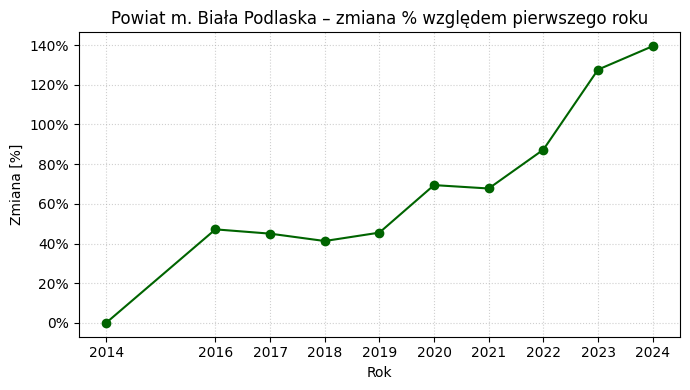

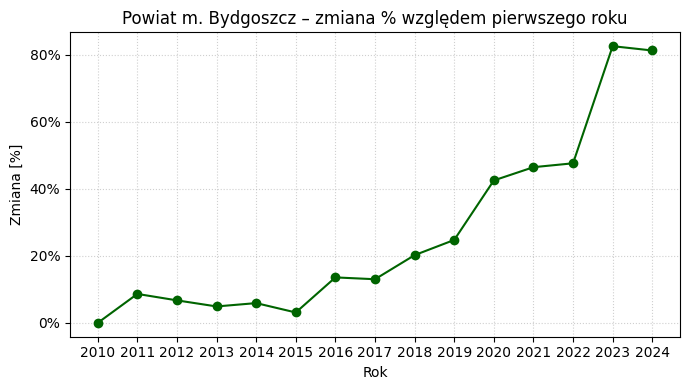

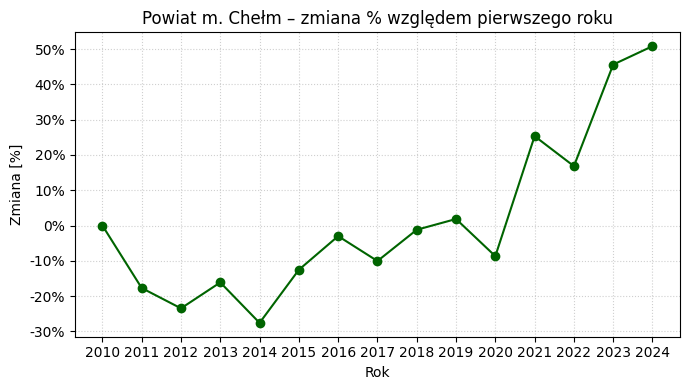

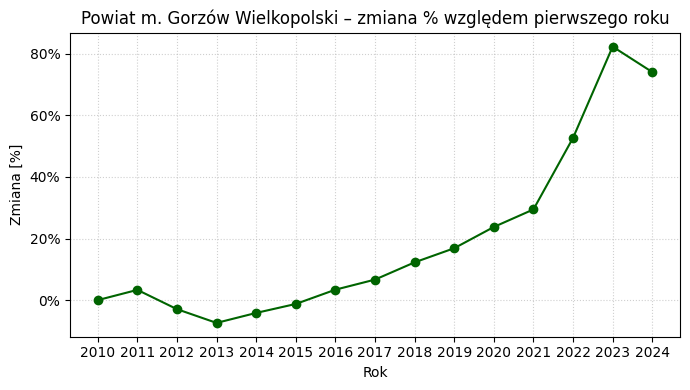

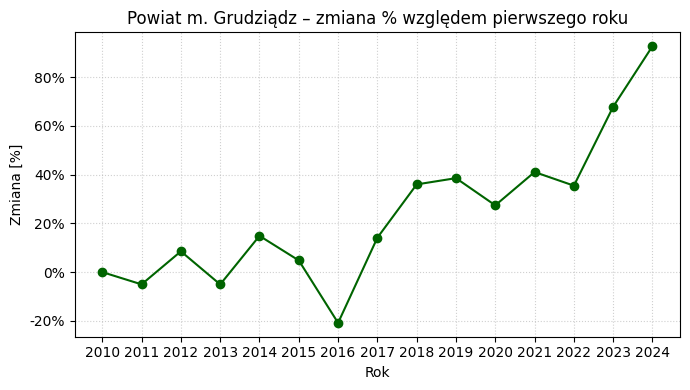

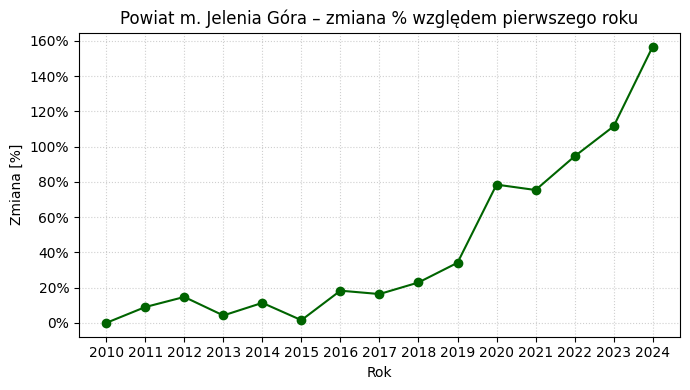

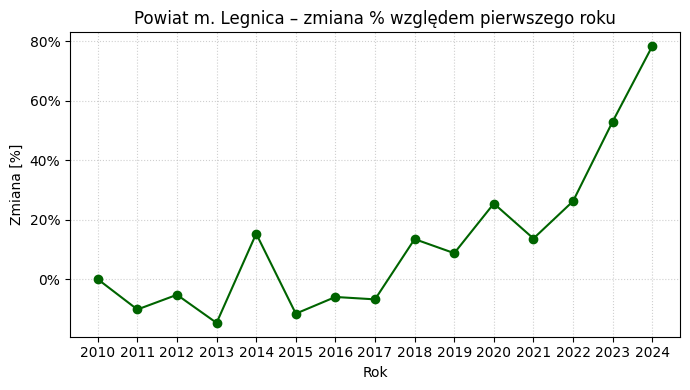

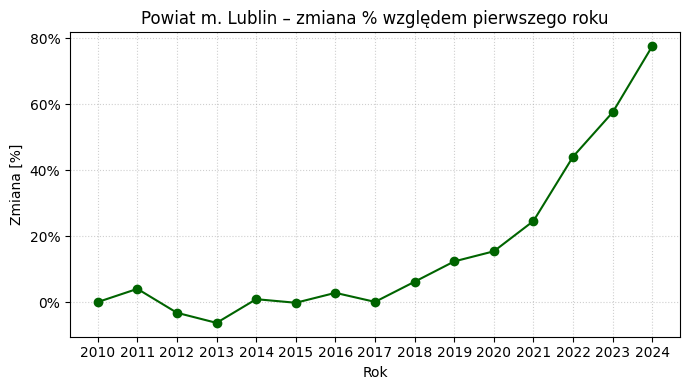

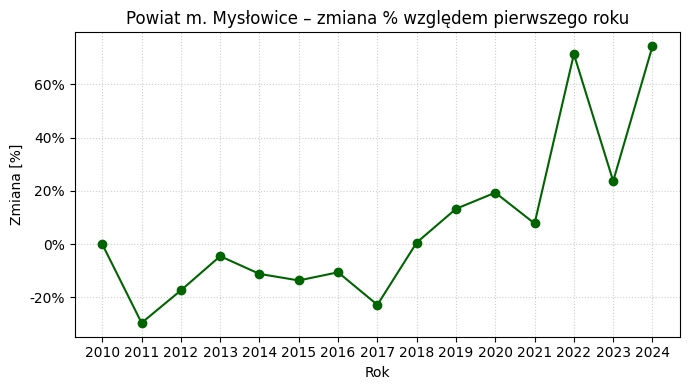

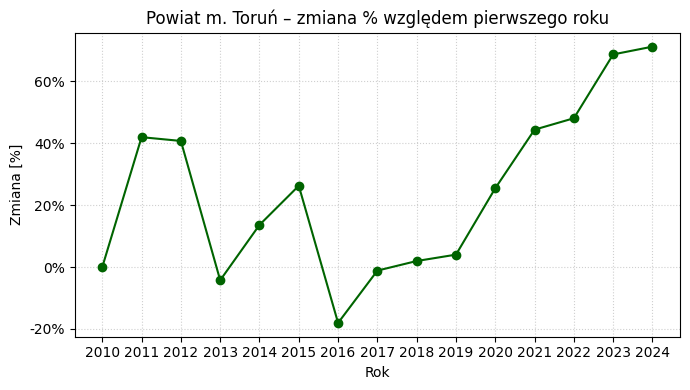

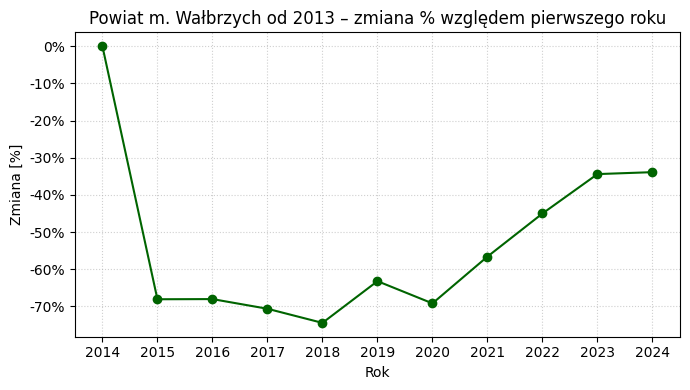

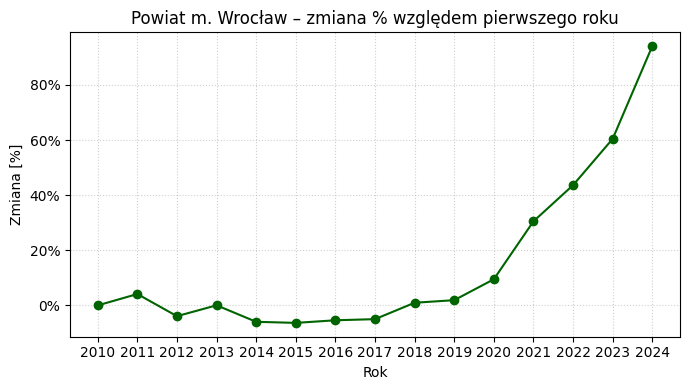

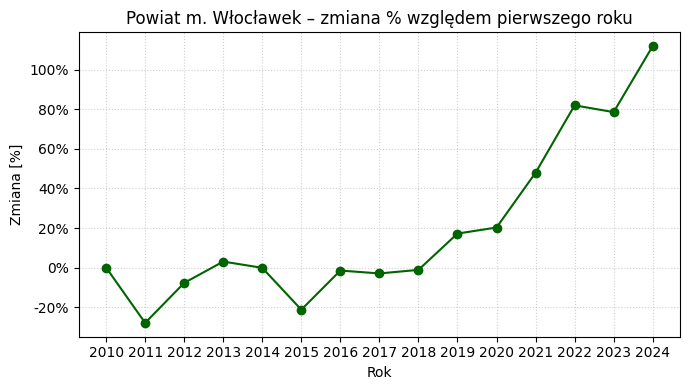

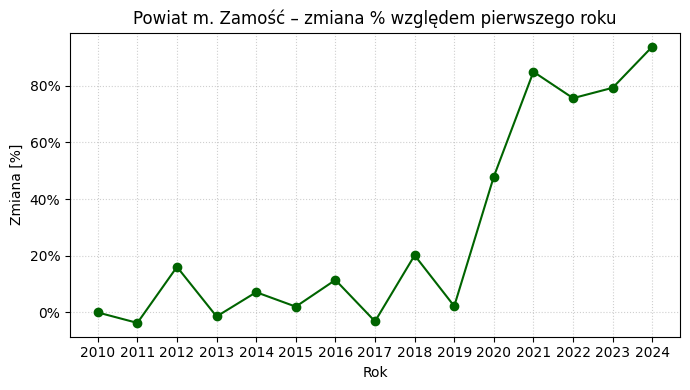

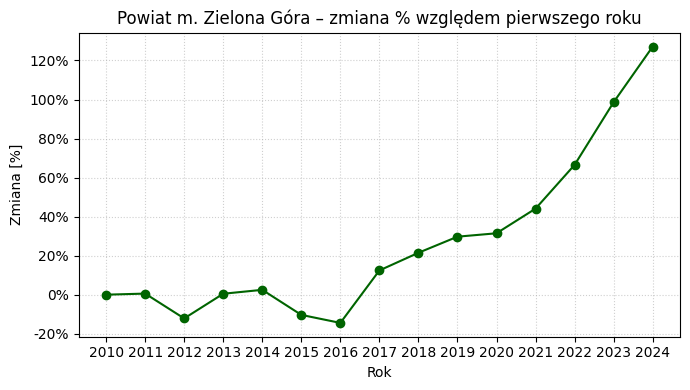

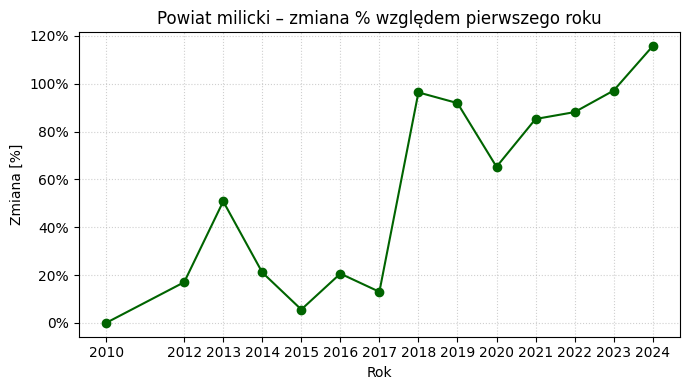

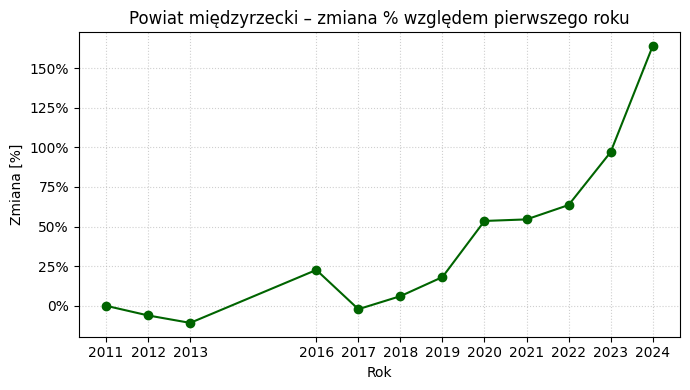

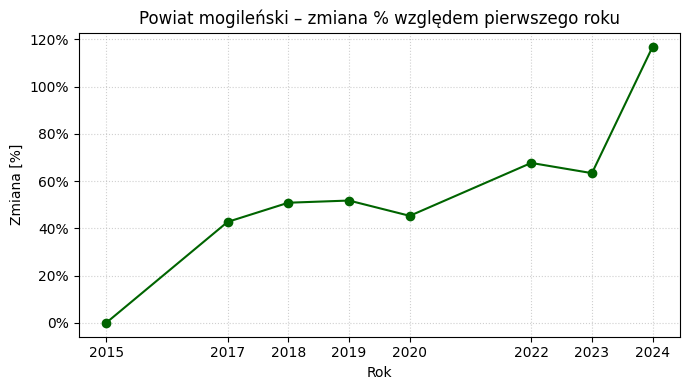

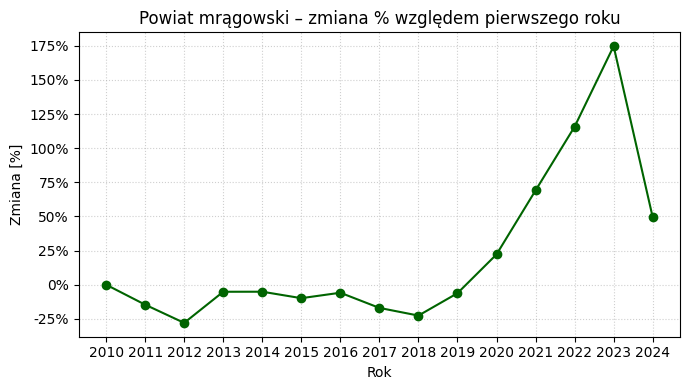

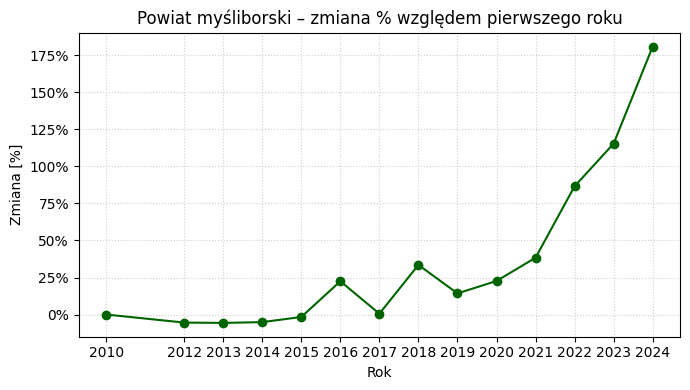

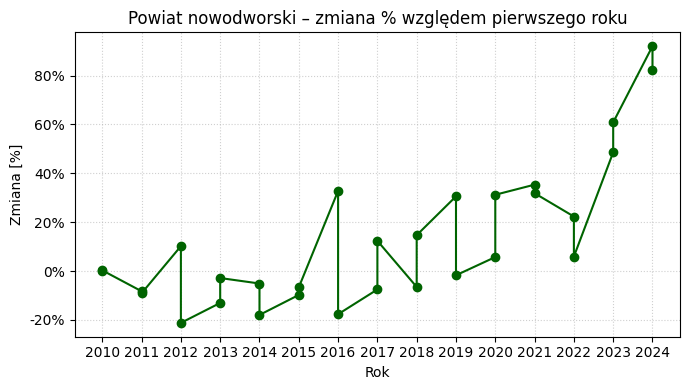

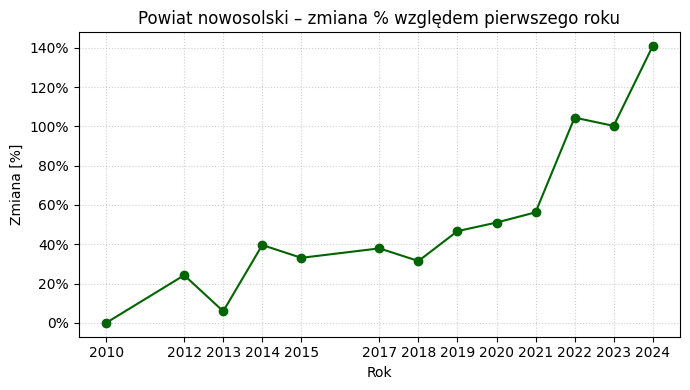

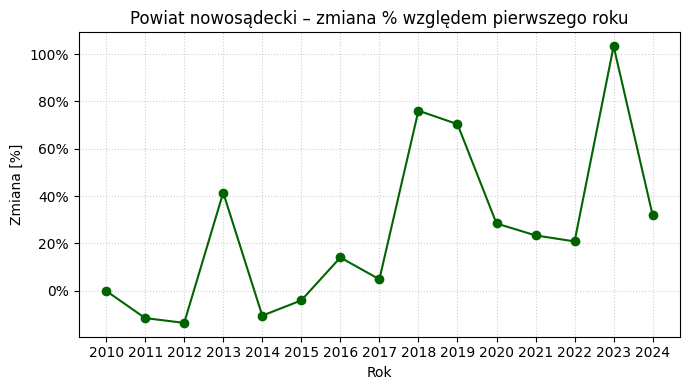

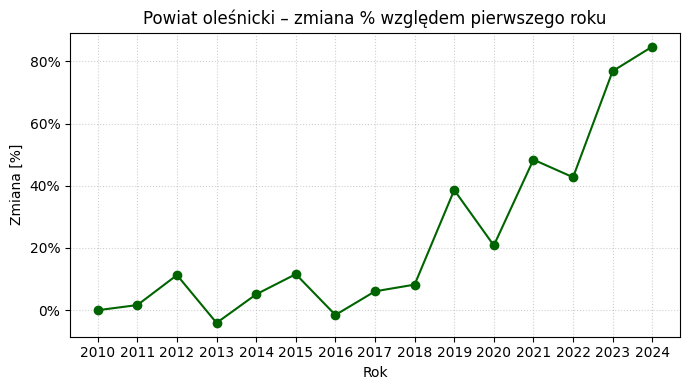

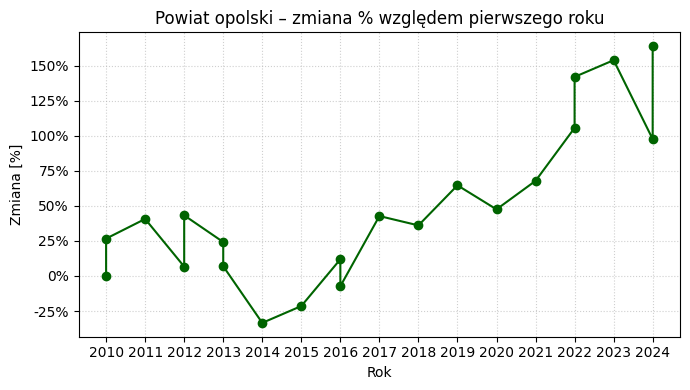

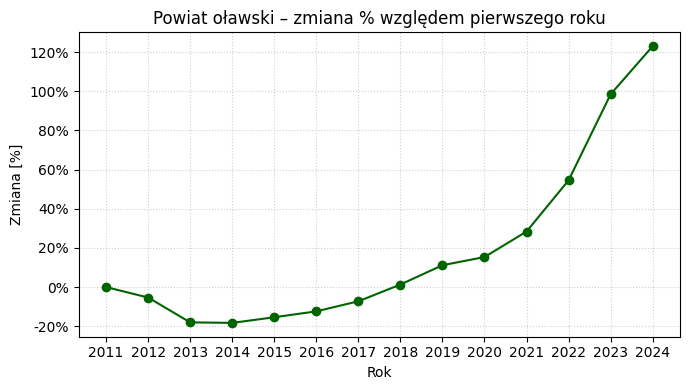

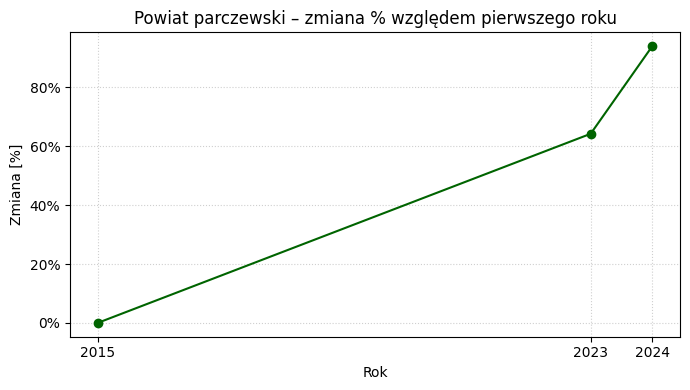

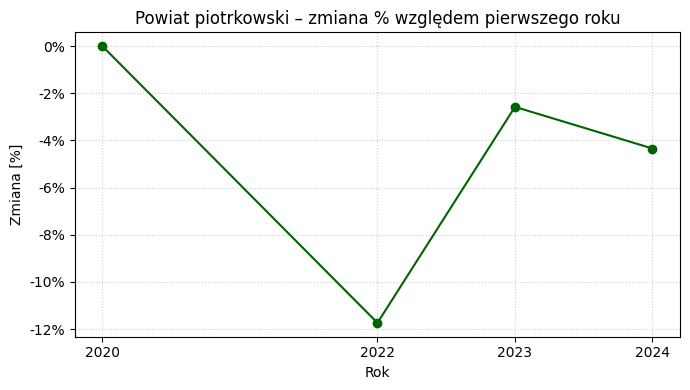

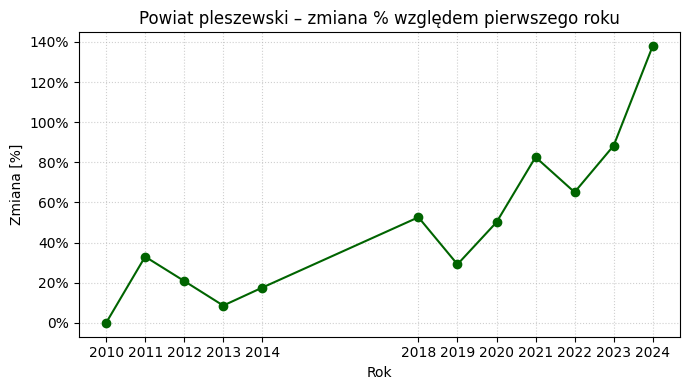

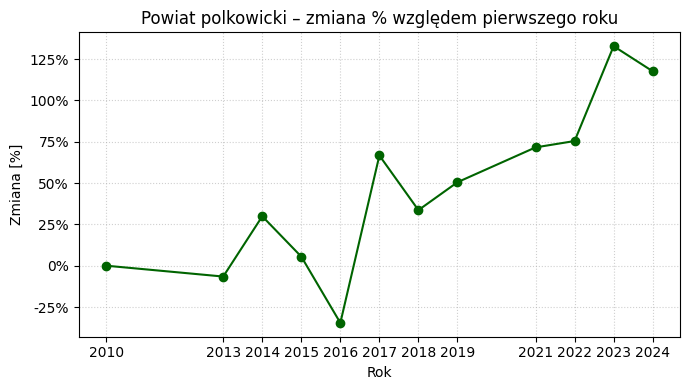

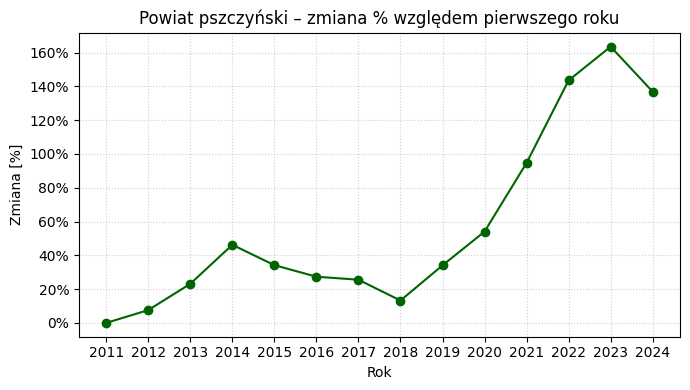

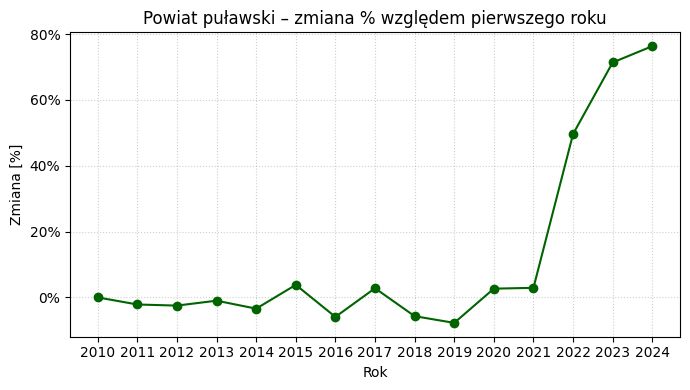

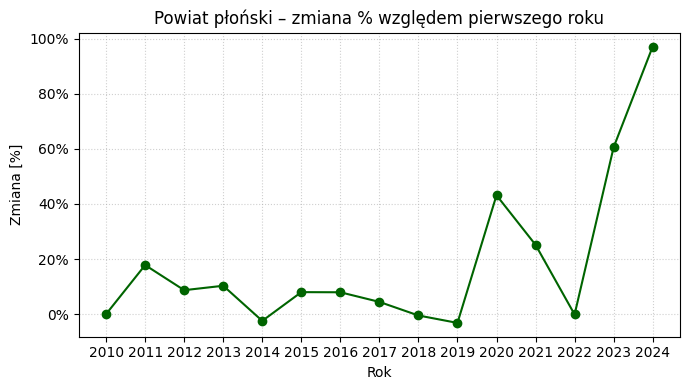

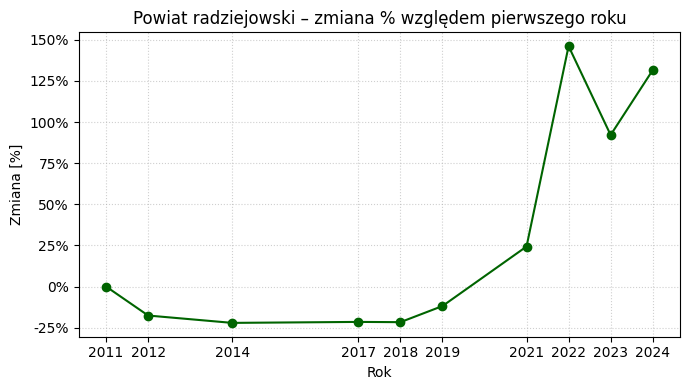

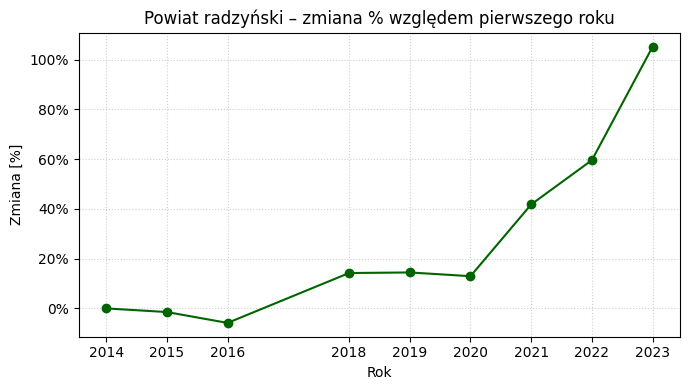

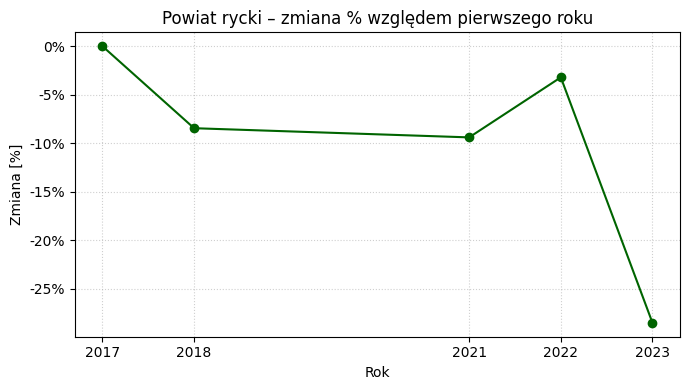

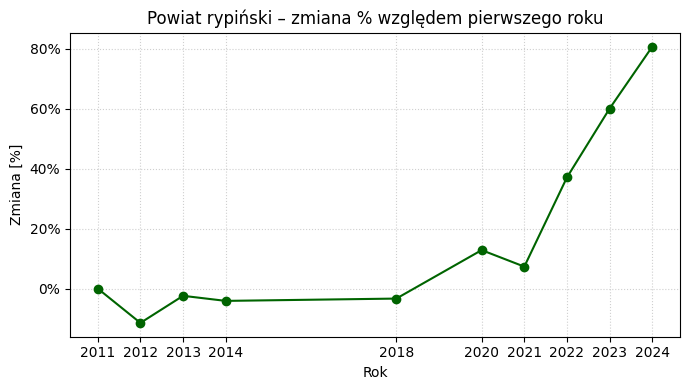

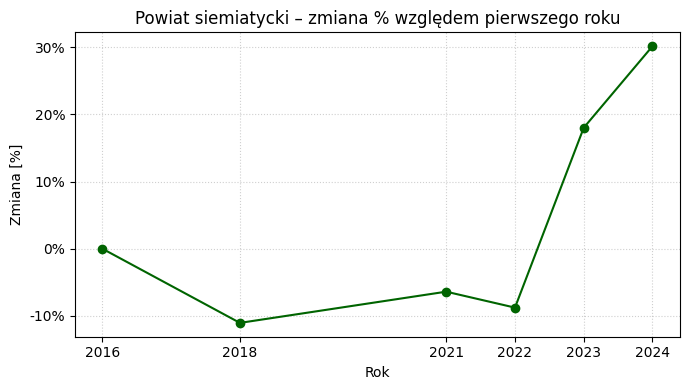

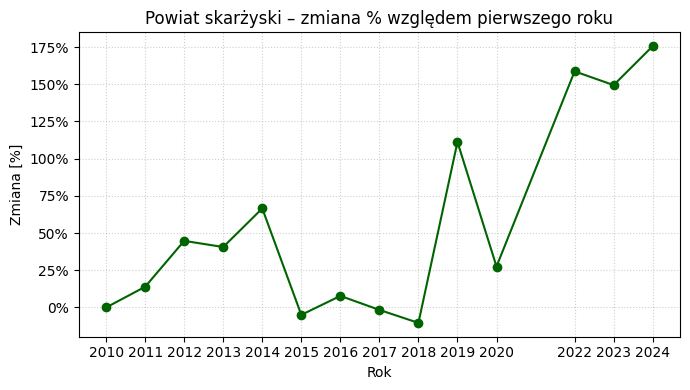

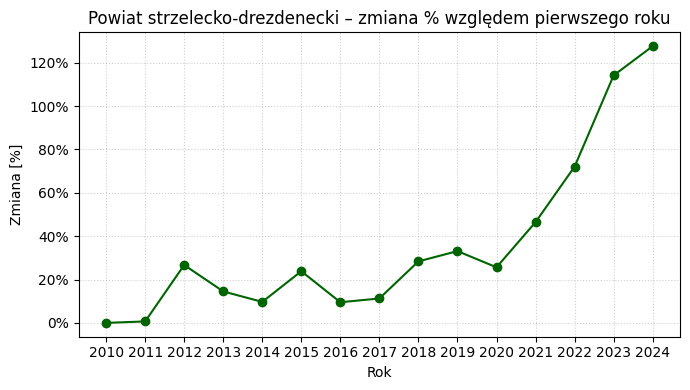

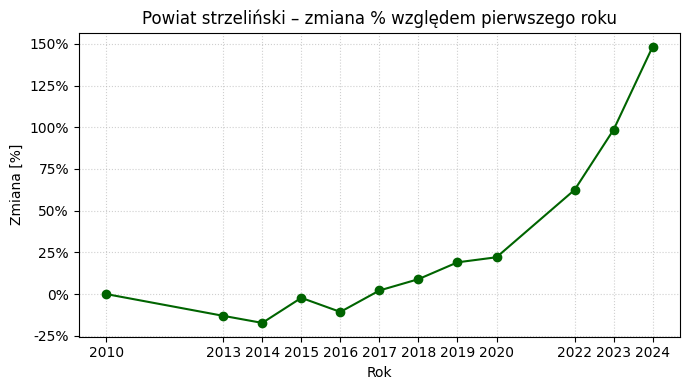

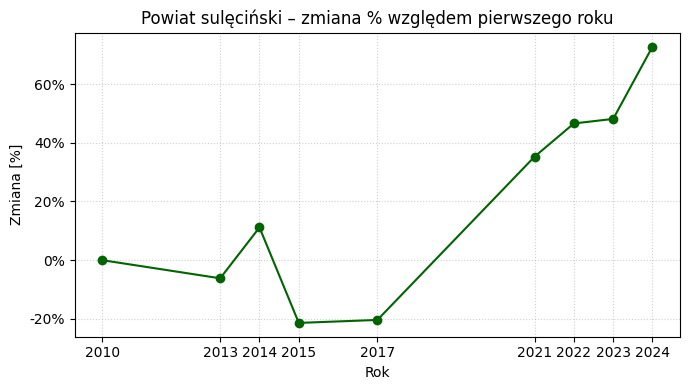

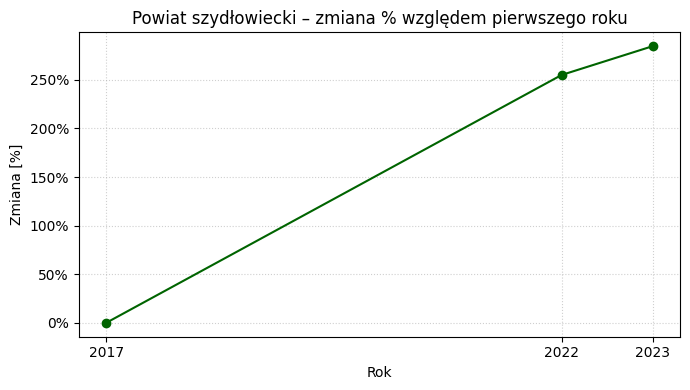

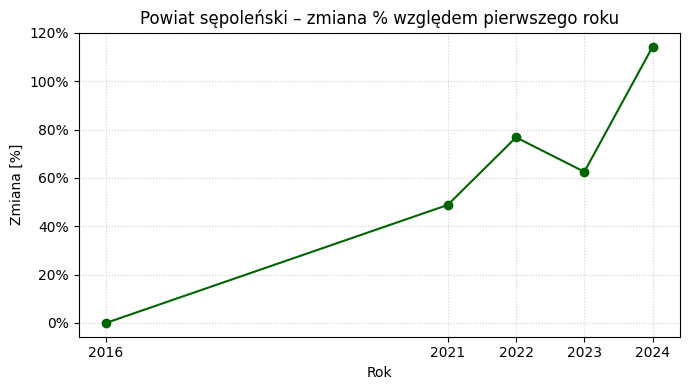

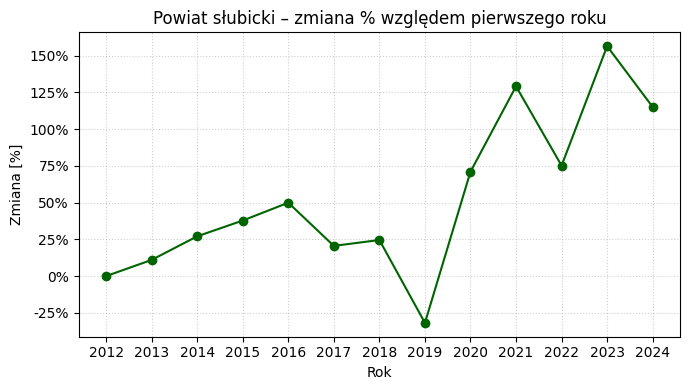

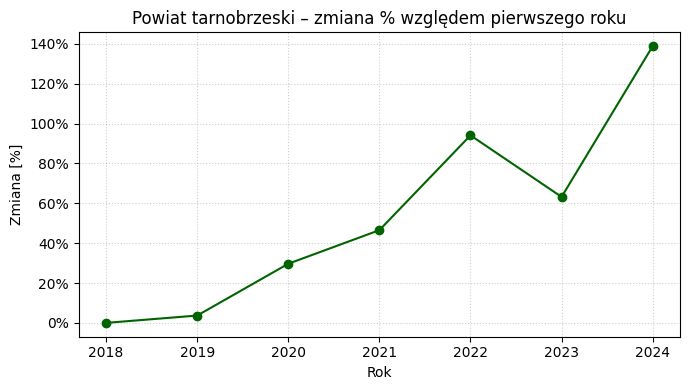

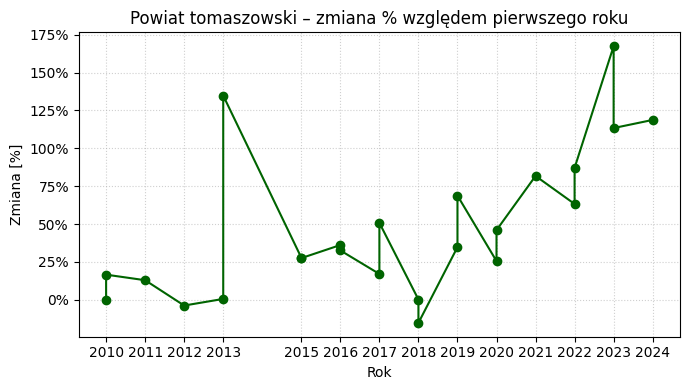

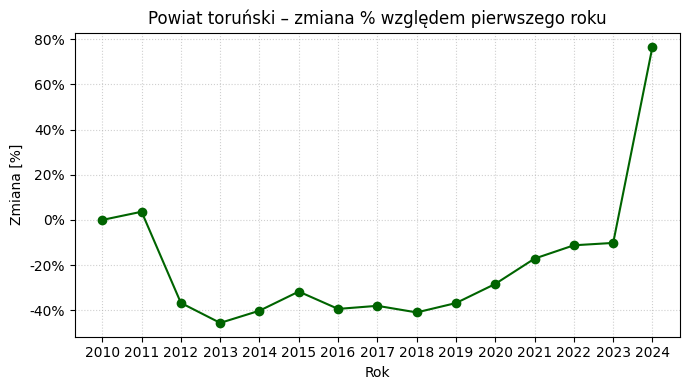

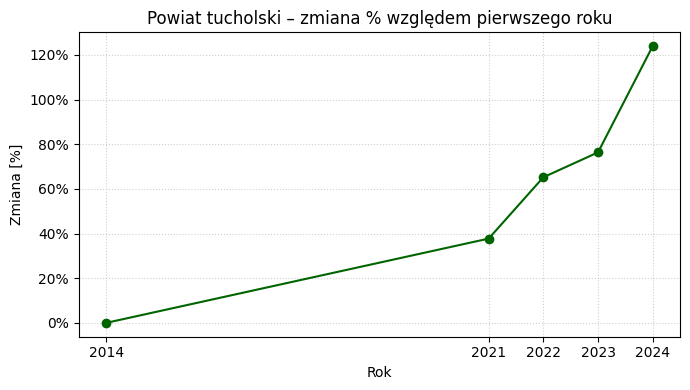

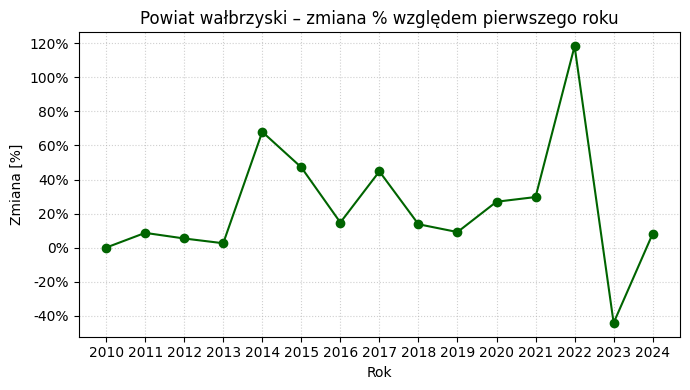

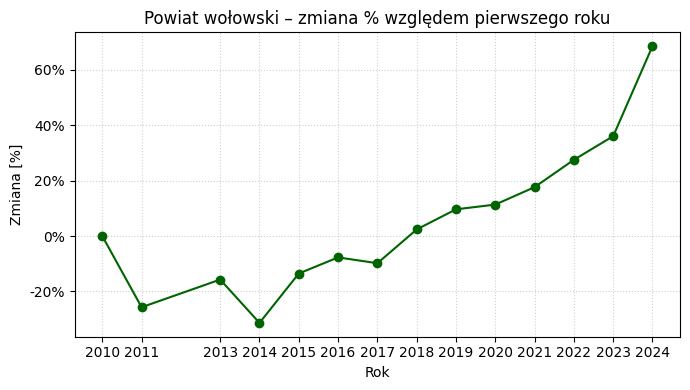

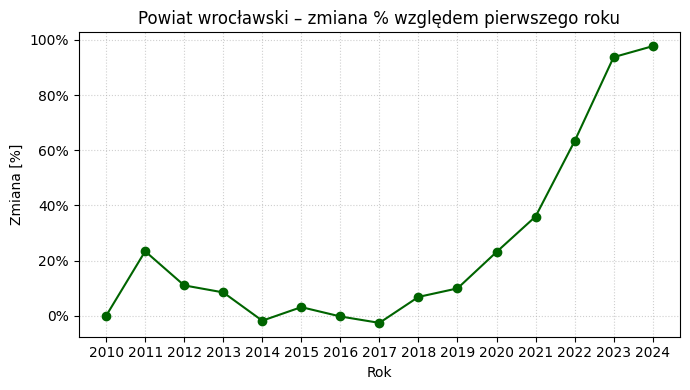

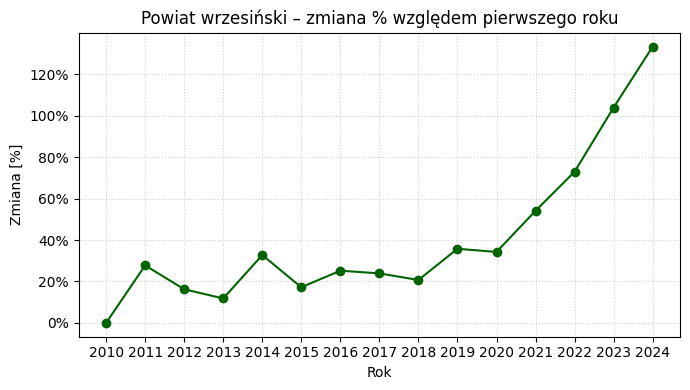

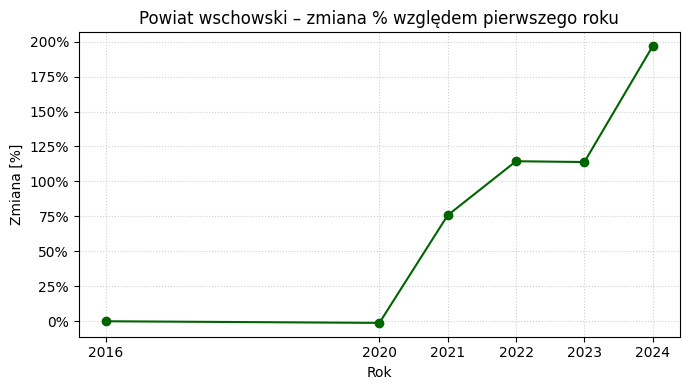

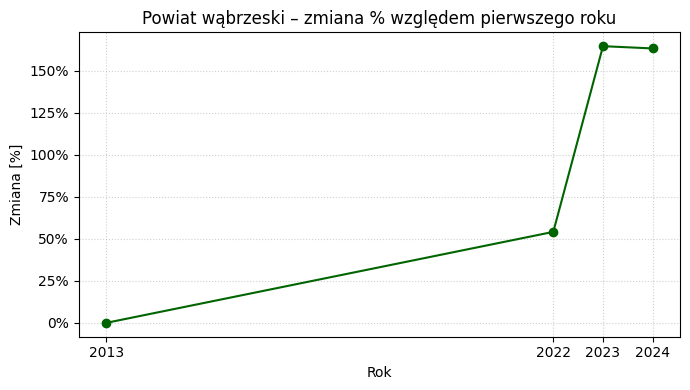

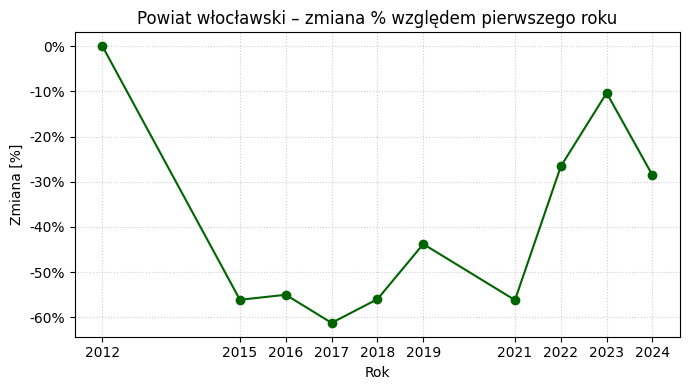

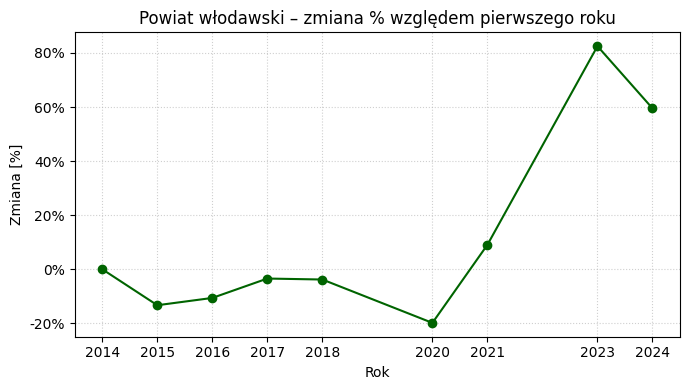

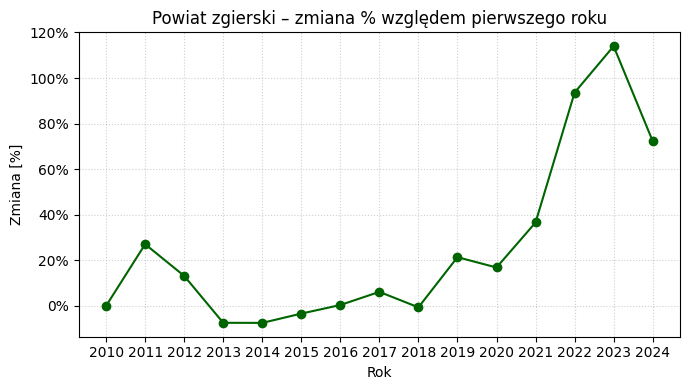

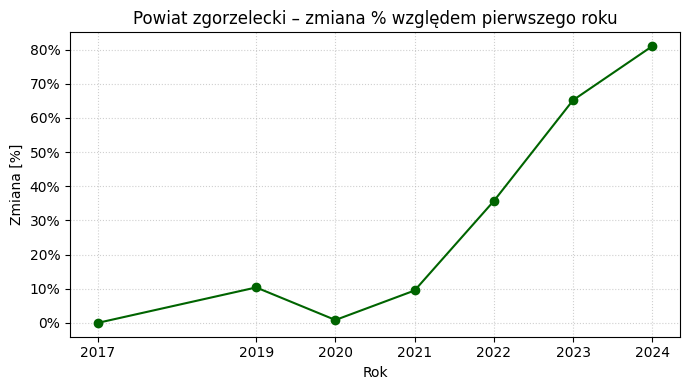

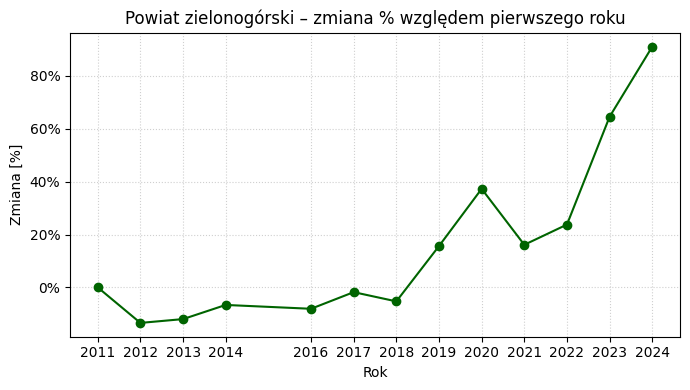

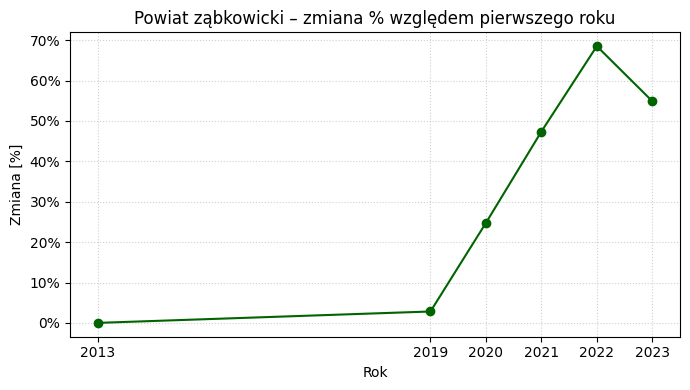

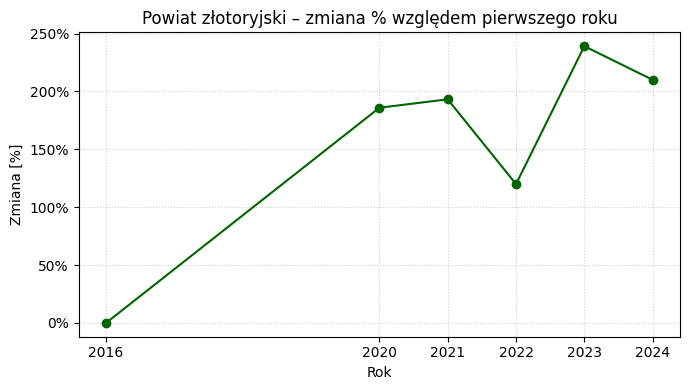

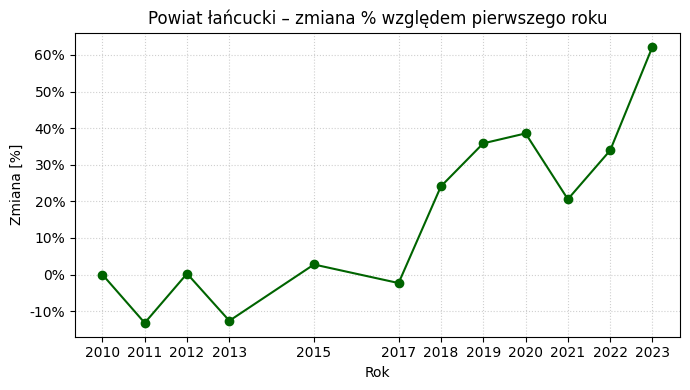

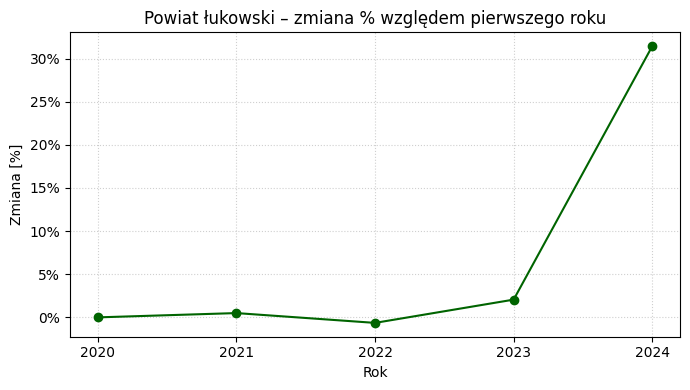

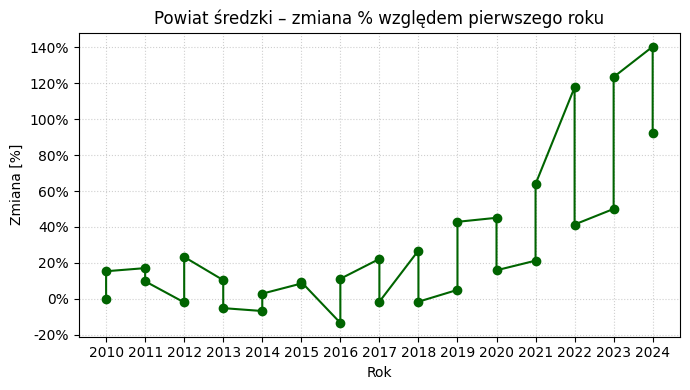

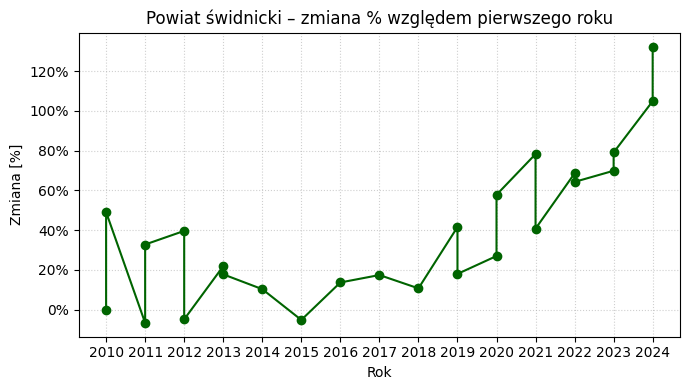

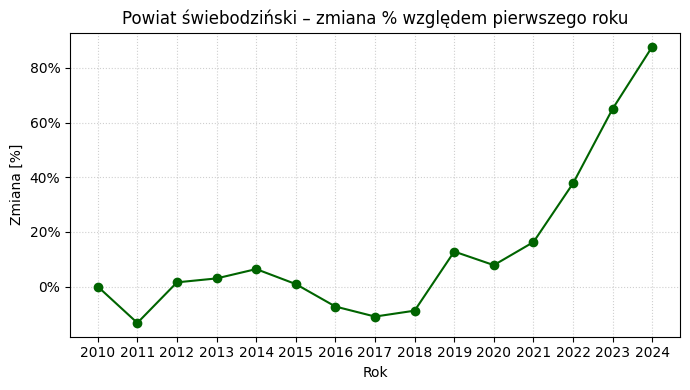

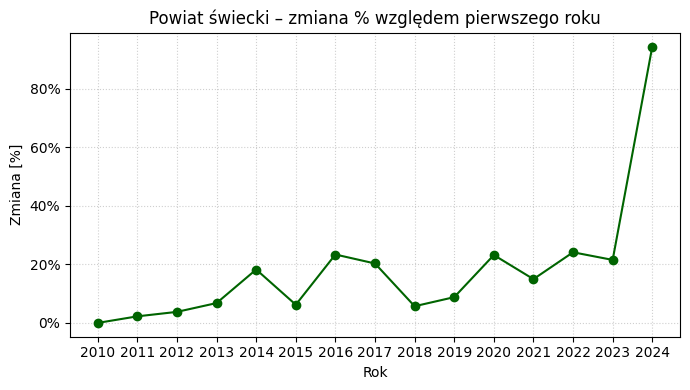

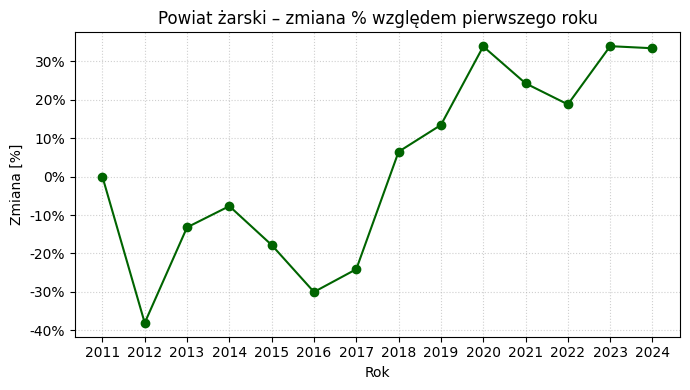

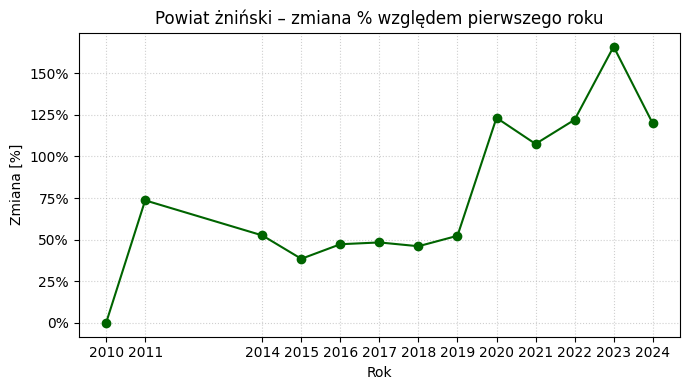


✓ Gotowe! Wygenerowano 98 wykresów.


In [295]:
# Pętla: wykresy TYLKO dla powiatów z min. 3 punktami danych
print(f"\nGenerowanie {len(good_powiats)} wykresów dla powiatów z wystarczającą ilością danych...")
for powiat_name in good_powiats:
    try:
        plot_powiat_percent(powiat_name)
    except ValueError as e:
        print(f"Błąd dla {powiat_name}: {e}")
        continue

print(f"\n✓ Gotowe! Wygenerowano {len(good_powiats)} wykresów.")
